In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed, AdditiveAttention, Concatenate
from tensorflow.keras.optimizers import Adam

2025-04-16 06:38:46.813368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744785527.006730      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744785527.068919      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=8524dfeea7fa179af6360e2c94fec086c4f91ac20e724f2d61c7b0f698f5f302
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [34]:
data = pd.read_csv('/kaggle/input/eurusd60/EURUSD-60-DS-redate.csv')
data.head()

Date     Open     High      Low    Close   Volume
0  15.08.2017 00:00:00.000  1.17786  1.17812  1.17750  1.17759  6070.48
1  15.08.2017 01:00:00.000  1.17759  1.17802  1.17752  1.17783  3163.99
2  15.08.2017 02:00:00.000  1.17783  1.17802  1.17682  1.17755  4086.81
3  15.08.2017 03:00:00.000  1.17757  1.17895  1.17751  1.17811  6937.33
4  15.08.2017 04:00:00.000  1.17812  1.17928  1.17812  1.17855  7265.10

In [35]:
import pandas_ta as ta
data['ema20'] = ta.ema(data['Close'],length=20)
data['ema50'] = ta.ema(data['Close'],length=50) # اختلاف قیمت

# انتخاب ویژگی‌های ورودی
features = ['ema20']
target = ['ema20']  # خروجی هدف
data.dropna(inplace=True)

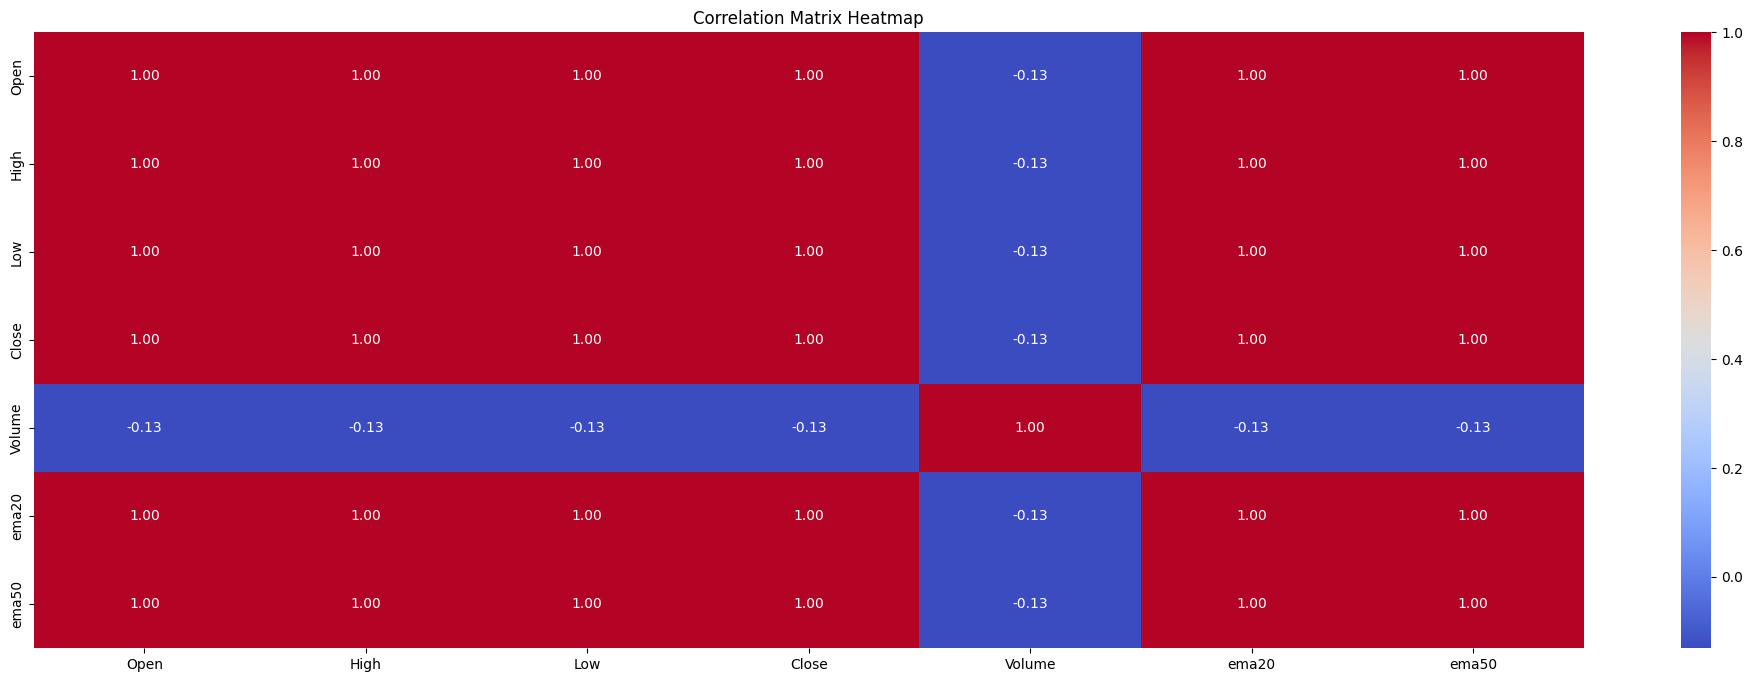

In [5]:
import seaborn as sns
correlation_matrix = data.drop(['Date'],axis=1).corr()
plt.figure(figsize=(25, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f",annot=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

/tmp/ipykernel_31/283547170.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # استفاده از تم seaborn برای ظاهر بهتر


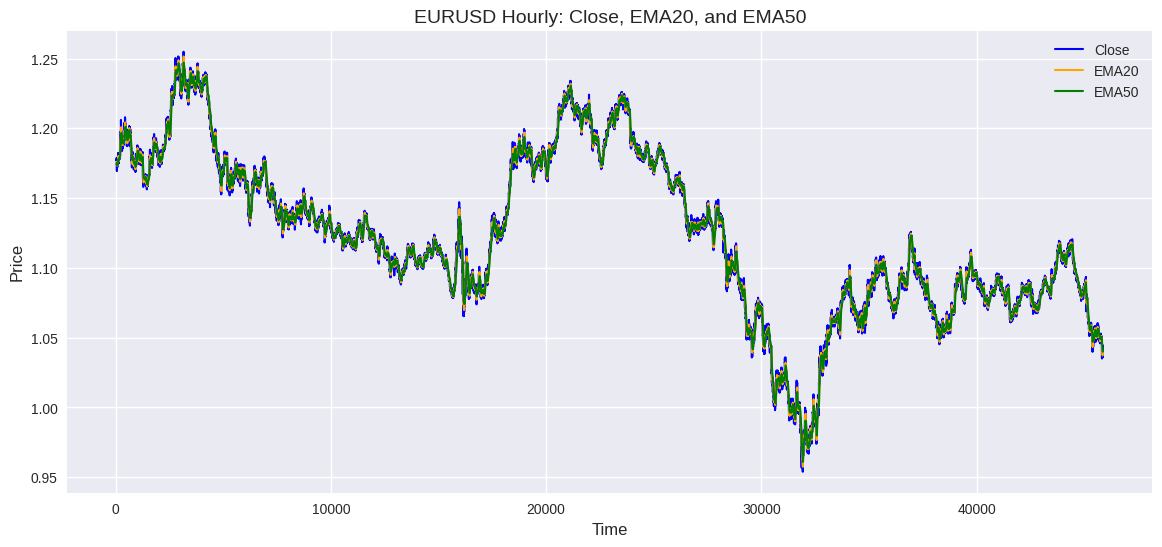

In [6]:
plt.style.use('seaborn')  # استفاده از تم seaborn برای ظاهر بهتر
plt.rcParams['figure.figsize'] = (14, 6)  # اندازه نمودا

# رسم لاین پلات
plt.plot(data['Close'], label='Close', color='blue', linewidth=1.5)
plt.plot(data['ema20'], label='EMA20', color='orange', linewidth=1.5)
plt.plot(data['ema50'], label='EMA50', color='green', linewidth=1.5)

# افزودن عنوان و برچسب‌ها
plt.title('EURUSD Hourly: Close, EMA20, and EMA50', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)

# نمایش لجند
plt.legend()

In [36]:
def prepare_data(data, features, target, seq_length=30, future_steps=15):
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    
    # نرمال‌سازی ویژگی‌ها و هدف
    data_scaled_features = scaler_features.fit_transform(data[features])
    data_scaled_target = scaler_target.fit_transform(data[target])
    
    X, y = [], []
    for i in range(len(data_scaled_features) - seq_length - future_steps):
        X.append(data_scaled_features[i:i+seq_length])
        y.append(data_scaled_target[i+seq_length:i+seq_length+future_steps])
    
    X = np.array(X)
    y = np.array(y)
    
    # تقسیم داده‌ها به train، validation و test
    train_size = int(0.7 * len(X))  # 70% برای آموزش
    val_size = int(0.15 * len(X))   # 15% برای اعتبارسنجی
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]
    
    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler_features, scaler_target

X_train, y_train, X_val, y_val, X_test, y_test, scaler_features, scaler_target = prepare_data(
    data, features, target, seq_length=72, future_steps=10)

In [37]:
del model

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


def build_encoder_decoder_model(seq_length, future_steps, n_features):
    # ورودی مدل
    encoder_inputs = Input(shape=(seq_length, n_features))
    
    # بخش Encoder
    encoder_lstm = LSTM(256, return_state=True)  # 100 واحد LSTM
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    # بخش Decoder
    decoder_inputs = RepeatVector(future_steps)(encoder_outputs)  # تکرار خروجی انکودر
    decoder_lstm = LSTM(256, return_sequences=True)(decoder_inputs, initial_state=encoder_states)
    
    # لایه خروجی
    decoder_dense = TimeDistributed(Dense(1))(decoder_lstm)  # خروجی برای هر گام زمانی
    
    # تعریف مدل
    model = Model(encoder_inputs, decoder_dense)
    return model

model = build_encoder_decoder_model(seq_length=72, future_steps=10, n_features=len(features))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mse', metrics=['mae','mape'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 72, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 256), (None,   │        264,192 │ input_layer_2[0][0]    │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 10, 256)        │              0 │ lstm_4[0][0]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 10, 256)        │        525,312 │ repeat_vector_2[0][0], │
│                           │                        │                │ lstm_4[0][1],          │
│                           │                        │                │ lstm_4[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 10, 1)          │            257 │ lstm_5[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 789,761 (3.01 MB)

 Trainable params: 789,761 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
# import pandas as pd
# import pandas_ta as ta
# import numpy as np
# import tensorflow as tf
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
# from tensorflow.keras.optimizers import Adam
# import matplotlib.pyplot as plt
# from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, MultiHeadAttention, Concatenate, TimeDistributed

# # def build_seq2seq_with_multihead_attention(seq_length, future_steps, n_features):
# #     # ورودی
# #     encoder_inputs = Input(shape=(seq_length, n_features))
    
# #     # انکودر
# #     encoder_lstm_1 = LSTM(100, activation='tanh', return_sequences=True)(encoder_inputs)
# #     encoder_dropout_1 = Dropout(0.2)(encoder_lstm_1)  # افزایش Dropout
# #     encoder_lstm_2, state_h, state_c = LSTM(100, activation='tanh', return_state=True)(encoder_dropout_1)
# #     encoder_states = [state_h, state_c]
    
# #     # دکودر
# #     decoder_inputs = RepeatVector(future_steps)(encoder_lstm_2)
# #     decoder_lstm_1 = LSTM(100, activation='tanh', return_sequences=True)(decoder_inputs, initial_state=encoder_states)
# #     decoder_dropout_1 = Dropout(0.2)(decoder_lstm_1)  # افزایش Dropout
# #     decoder_lstm_2 = LSTM(100, activation='tanh', return_sequences=True)(decoder_dropout_1)
    
# #     # MultiHeadAttention
# #     attention = MultiHeadAttention(num_heads=4, key_dim=100 // 4)(query=decoder_lstm_2, key=encoder_dropout_1, value=encoder_dropout_1)
# #     concat = Concatenate()([decoder_lstm_2, attention])
    
# #     # خروجی
# #     decoder_dense = TimeDistributed(Dense(1))(concat)
    
# #     # تعریف مدل
# #     model = Model(inputs=encoder_inputs, outputs=decoder_dense)
# #     model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae','mape'])  # کاهش نرخ یادگیری
# #     return model
# # # ساخت مدل

# def build_simple_seq2seq(seq_length, future_steps, n_features):
#     encoder_inputs = Input(shape=(seq_length, n_features))
#     encoder_lstm = LSTM(50, activation='tanh', return_sequences=False)(encoder_inputs)
#     encoder_dropout = Dropout(0.2)(encoder_lstm)
    
#     decoder_inputs = RepeatVector(future_steps)(encoder_dropout)
#     decoder_lstm = LSTM(50, activation='tanh', return_sequences=True)(decoder_inputs)
#     decoder_dropout = Dropout(0.2)(decoder_lstm)
    
#     decoder_dense = TimeDistributed(Dense(1))(decoder_dropout)  # خروجی فقط ema20
#     model = Model(inputs=encoder_inputs, outputs=decoder_dense)
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae','mape'])
#     return model
    
# # model = build_seq2seq_with_attention(seq_length=30, future_steps=15, n_features=len(features))
# # model.summary()
# # def build_seq2seq_model(seq_length, future_steps):
# #     model = Sequential()
# #     model.add(LSTM(100, activation='relu', input_shape=(seq_length, len(features)), return_sequences=False))
# #     model.add(RepeatVector(future_steps))
# #     model.add(LSTM(100, activation='relu', return_sequences=True))
# #     model.add(TimeDistributed(Dense(2)))
# #     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',metrics=['mae'])
# #     return model

# # model = build_seq2seq_model(seq_length=30, future_steps=15)
# # model.summary()

# # def build_lstm_model(seq_length, future_steps, n_features):
# #     model = Sequential()
# #     model.add(LSTM(64, activation='tanh', input_shape=(seq_length, n_features), return_sequences=True))
# #     model.add(Dropout(0.2))
# #     model.add(LSTM(32, activation='tanh', return_sequences=False))
# #     model.add(Dropout(0.2))
# #     model.add(Dense(future_steps * 2))  # 24 تایم‌فریم × 2 متغیر (ema20 و ema50)
# #     model.add(tf.keras.layers.Reshape((future_steps, 2)))  # تغییر شکل خروجی به (future_steps, 2)
# #     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
# #     return model

# model = build_simple_seq2seq(seq_length=30, future_steps=15, n_features=len(features))
# model.summary()

In [39]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

def warmup_schedule(epoch):
    warmup_epochs = 8
    initial_lr = 1e-5
    target_lr = 1e-3
    if epoch < warmup_epochs:
        lr = initial_lr + (target_lr - initial_lr) * (epoch / warmup_epochs)
        print(f'Epoch {epoch+1}: Setting learning rate to {lr:.6f}')
        return lr
    print(f'Epoch {epoch+1}: Setting learning rate to {target_lr:.6f}')
    return target_lr

# تعریف callbackها
warmup_lr = LearningRateScheduler(warmup_schedule)

# تعریف EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # معیار مانیتورینگ
    patience=10,                  # تعداد epochهایی که صبر می‌کنه
    restore_best_weights=False,   # وزن‌ها به بهترین حالت برنمی‌گردن
    start_from_epoch=10,          # از epoch دهم شروع به چک کردن می‌کنه
    verbose=1                     # گزارش رو چاپ می‌کنه
)

# تعریف ReduceLROnPlateau برای تنظیم نرخ یادگیری
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # معیار مانیتورینگ
    factor=0.20,                  # ضریب کاهش نرخ یادگیری
    patience=5,                   # تعداد epochهایی که صبر می‌کنه
    min_lr=1e-7,                  # حداقل نرخ یادگیری
    verbose=1                     # گزارش تغییرات رو چاپ می‌کنه
)

# warmup_lr = WarmUpLearningRate(
#     warmup_epochs=5,          # 5 epoch برای Warm-up
#     initial_lr=1e-5,          # نرخ یادگیری اولیه
#     target_lr=1e-3            # نرخ یادگیری هدف
# )

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[warmup_lr, early_stopping, reduce_lr],
    verbose=1
)

Epoch 1: Setting learning rate to 0.000010
Epoch 1/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.1296 - mae: 0.2430 - mape: 1940.1588 - val_loss: 3.3212e-04 - val_mae: 0.0131 - val_mape: 6.8954 - learning_rate: 1.0000e-05
Epoch 2: Setting learning rate to 0.000134
Epoch 2/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1.6390e-04 - mae: 0.0092 - mape: 682.9642 - val_loss: 9.5153e-05 - val_mae: 0.0074 - val_mape: 2.7755 - learning_rate: 1.3375e-04
Epoch 3: Setting learning rate to 0.000258
Epoch 3/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 8.8258e-05 - mae: 0.0073 - mape: 402.9935 - val_loss: 9.1062e-05 - val_mae: 0.0075 - val_mape: 2.5057 - learning_rate: 2.5750e-04
Epoch 4: Setting learning rate to 0.000381
Epoch 4/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 8.7217e-05 - mae: 0.0072 - mape: 578.8856 - val_loss: 5.2482e-05 - val_mae: 0.0053 - val_mape: 1.8569 - learning_rate: 3.8125e-04
Epoch 5: Setting learning rate to 0.000505
Epoch 5/100
10

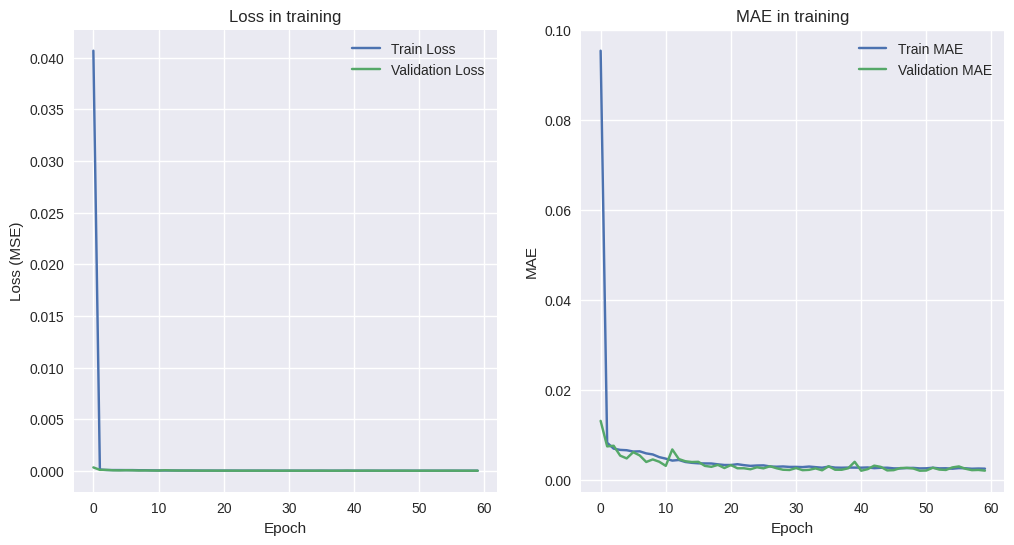

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [41]:
y_pred = model.predict(X_test)

# معکوس کردن مقیاس برای تفسیر
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)



215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [42]:
y_pred_rescaled[0]

array([[1.0816665],
       [1.0822643],
       [1.0825877],
       [1.0829129],
       [1.0832165],
       [1.083511 ],
       [1.0837923],
       [1.0840541],
       [1.0842927],
       [1.0845075]], dtype=float32)

In [43]:
y_test_rescaled[0]

array([[1.08175458],
       [1.08227224],
       [1.08280346],
       [1.08331741],
       [1.08374147],
       [1.08407752],
       [1.08438442],
       [1.08465924],
       [1.08488598],
       [1.08491684]])

/tmp/ipykernel_31/1283517414.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


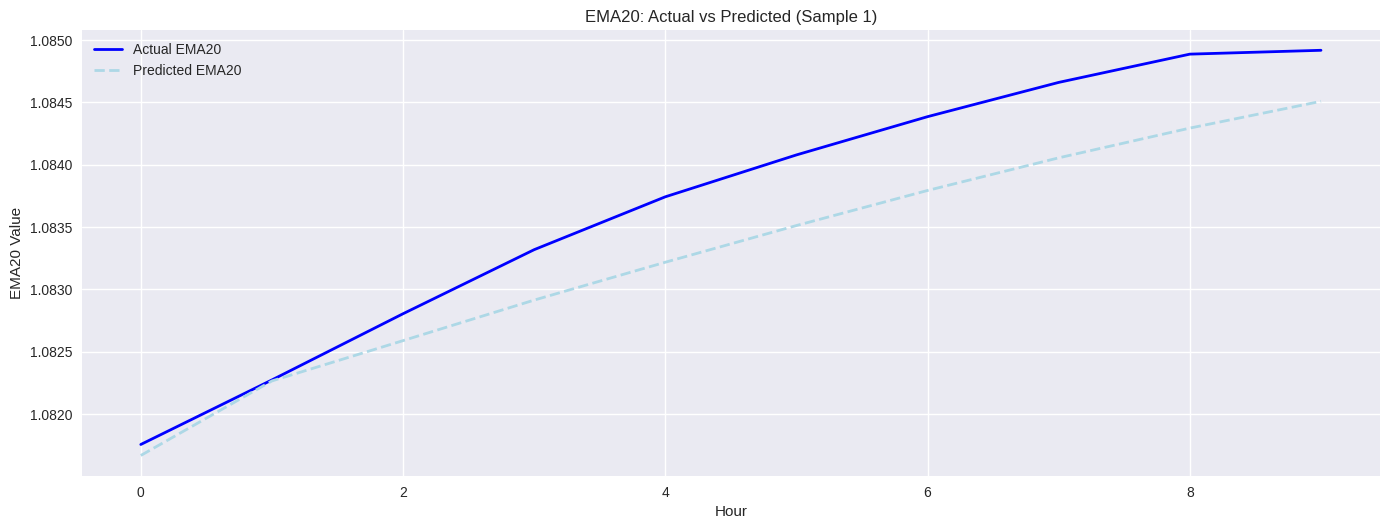

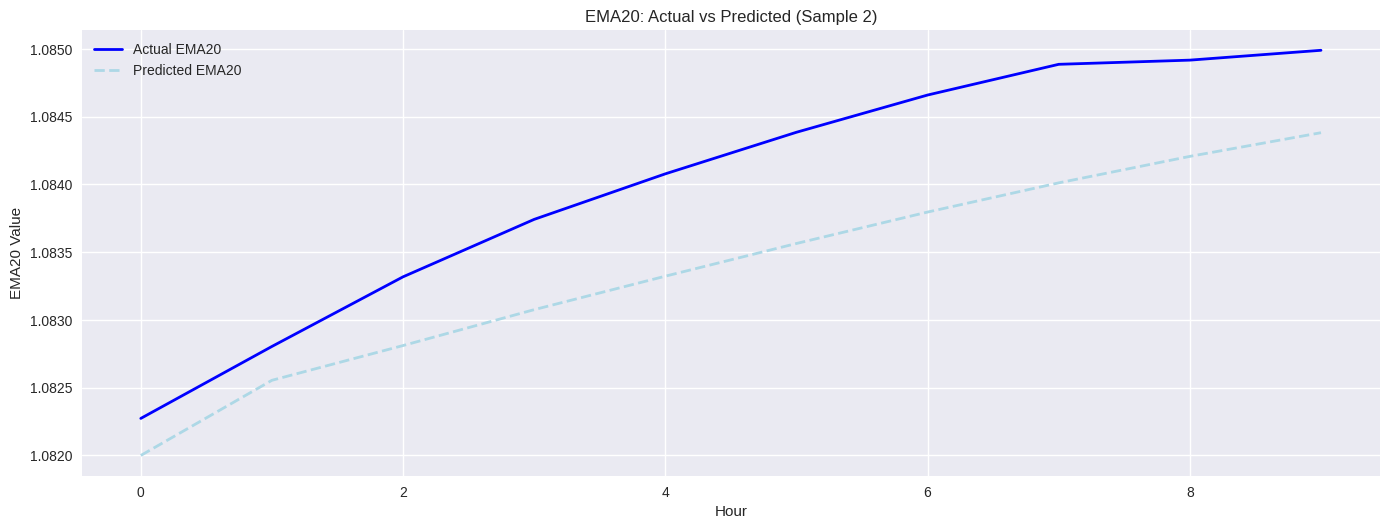

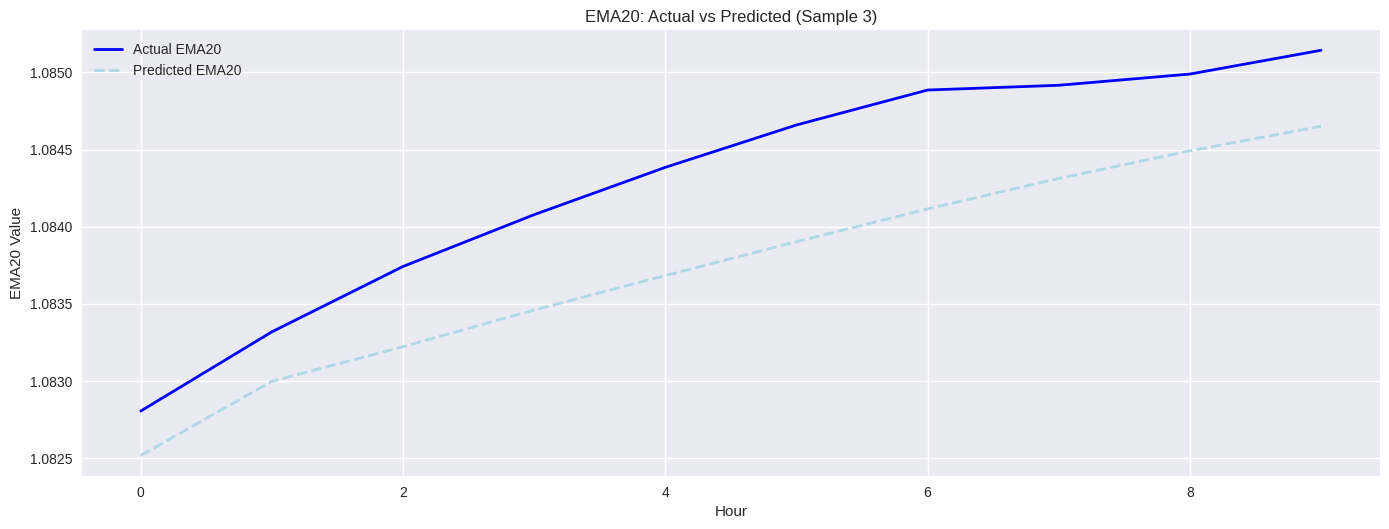

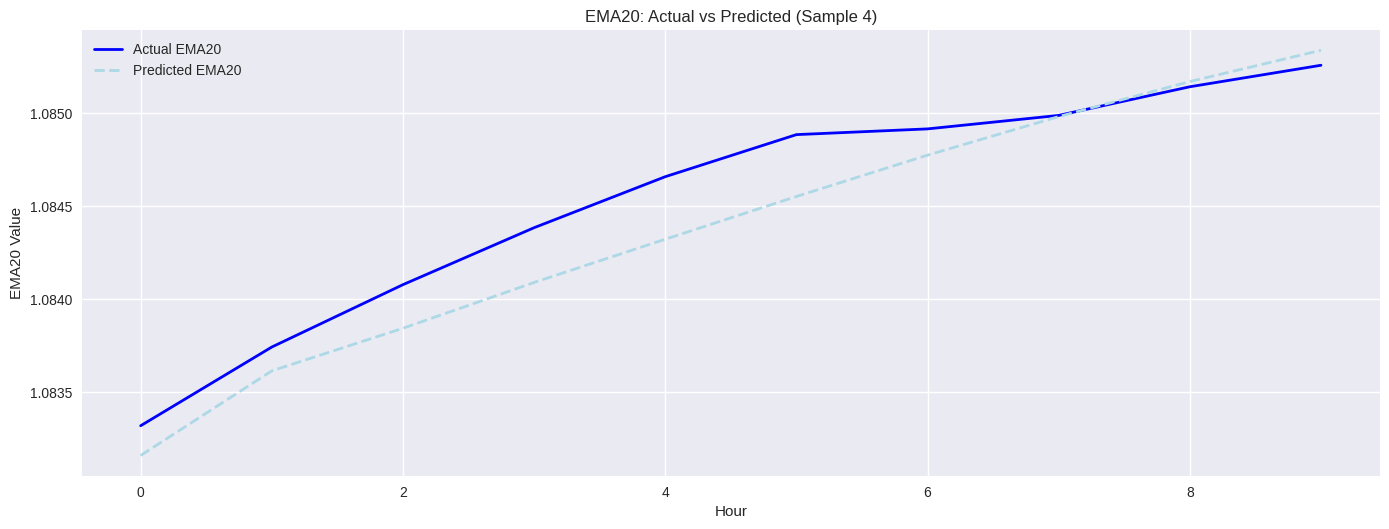

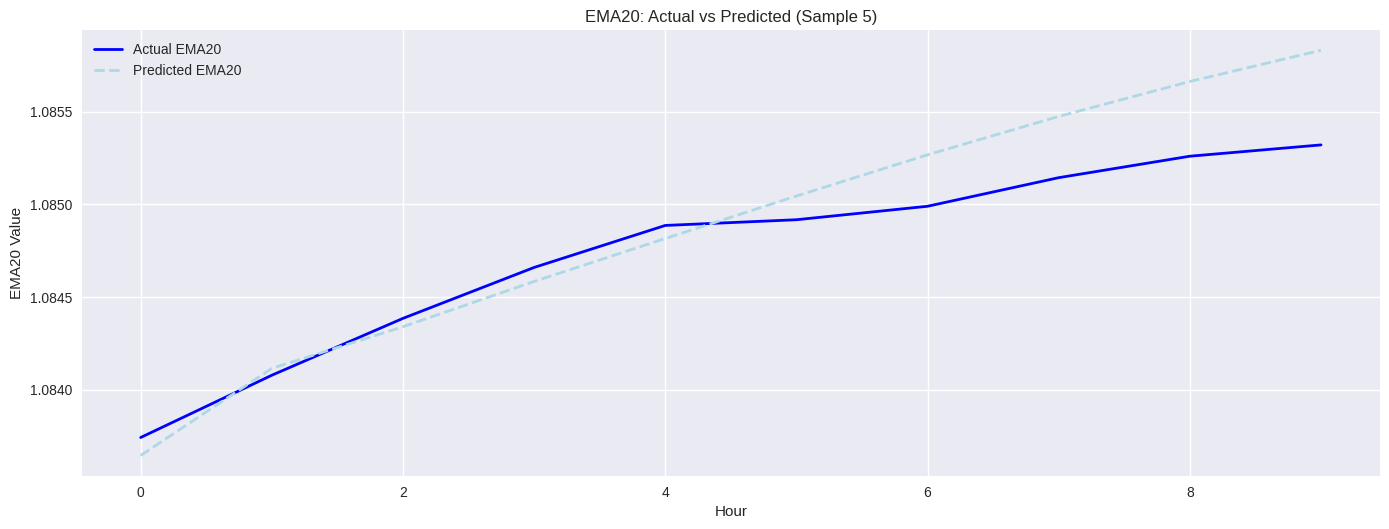

معیارهای دقت برای EMA20:
MSE: 0.000000
MAE: 0.000418


In [44]:
import matplotlib.pyplot as plt
import numpy as np

# تنظیمات ظاهری نمودار
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14, 10)

# انتخاب تعداد نمونه‌ها برای نمایش (مثلاً 5 سری پیش‌بینی)
n_samples_to_plot = 5

# رسم نمودار برای EMA20 و EMA50
for sample_idx in range(min(n_samples_to_plot, y_test_rescaled.shape[0])):
    # داده‌های واقعی و پیش‌بینی‌شده برای نمونه خاص
    actual_ema20 = y_test_rescaled[sample_idx, :, 0]  # EMA20 واقعی
    pred_ema20 = y_pred_rescaled[sample_idx, :, 0]    # EMA20 پیش‌بینی‌شده
    
    # ایجاد نمودار
    plt.figure()
    
    # نمودار برای EMA20
    plt.subplot(2, 1, 1)
    plt.plot(actual_ema20, label='Actual EMA20', color='blue', linewidth=2)
    plt.plot(pred_ema20, label='Predicted EMA20', color='lightblue', linestyle='--', linewidth=2)
    plt.title(f'EMA20: Actual vs Predicted (Sample {sample_idx + 1})')
    plt.xlabel('Hour')
    plt.ylabel('EMA20 Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# محاسبه و نمایش معیارهای دقت (MSE و MAE)
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_ema20 = mean_squared_error(y_test_rescaled[:, :, 0].flatten(), y_pred_rescaled[:, :, 0].flatten())
mae_ema20 = mean_absolute_error(y_test_rescaled[:, :, 0].flatten(), y_pred_rescaled[:, :, 0].flatten())


print("معیارهای دقت برای EMA20:")
print(f"MSE: {mse_ema20:.6f}")
print(f"MAE: {mae_ema20:.6f}")


/tmp/ipykernel_31/3625182402.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


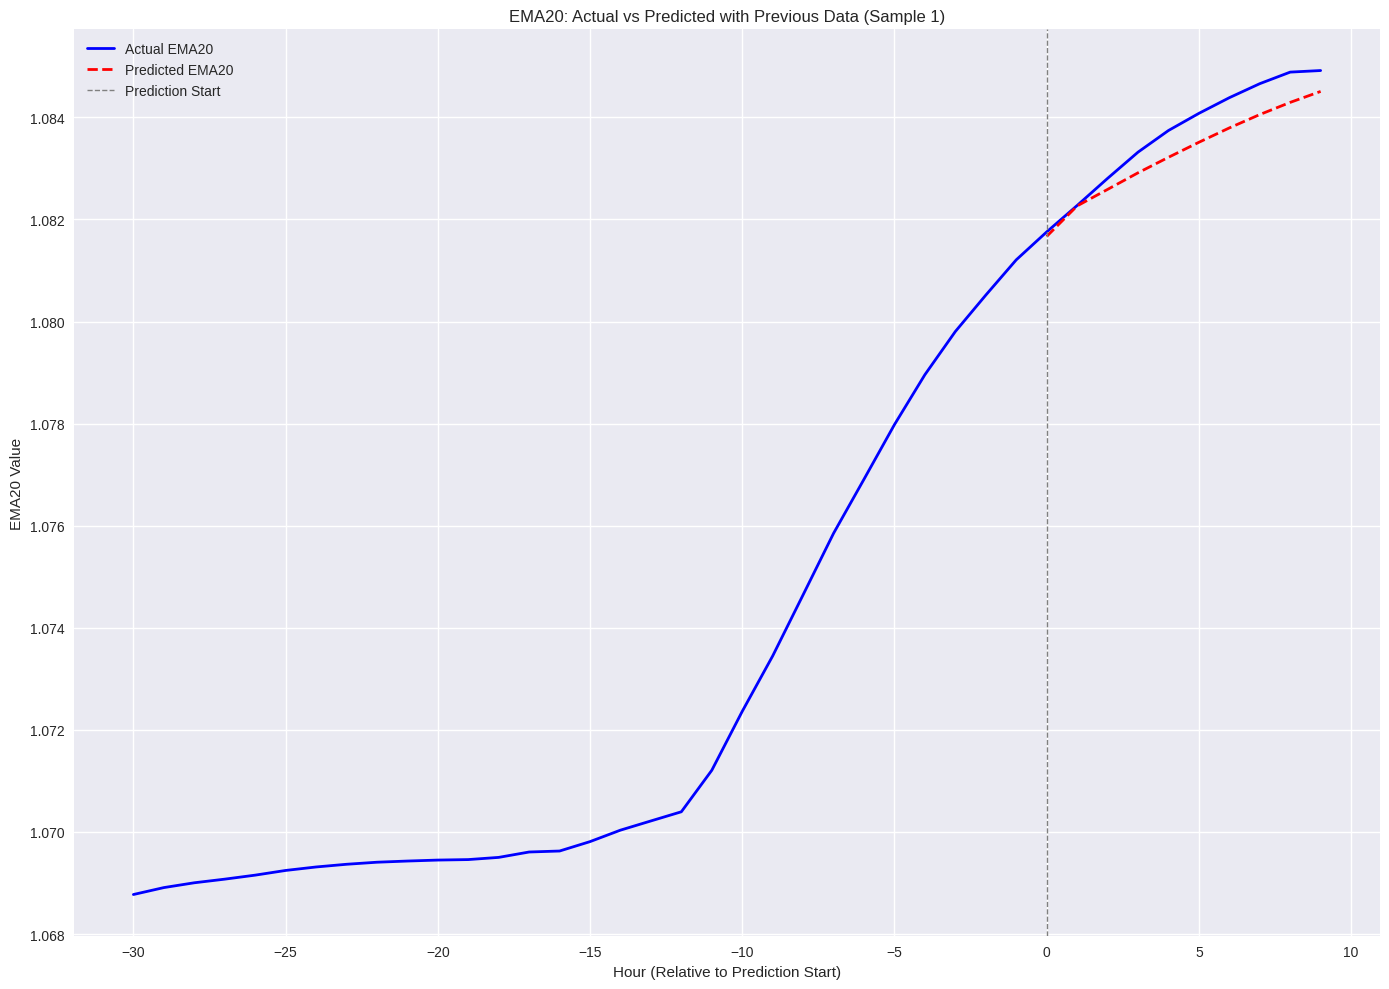

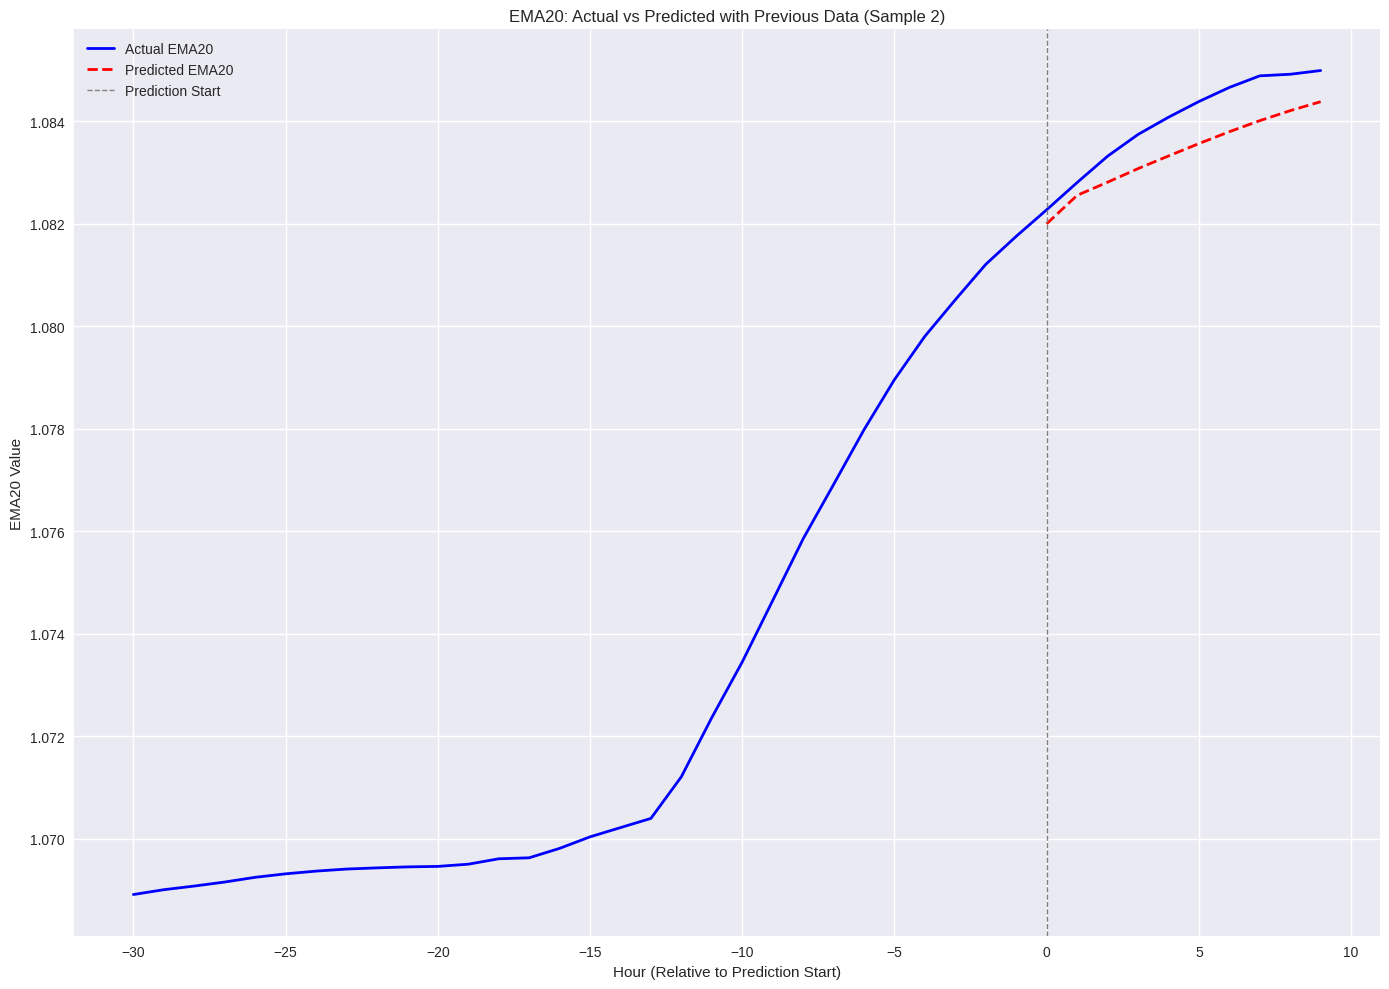

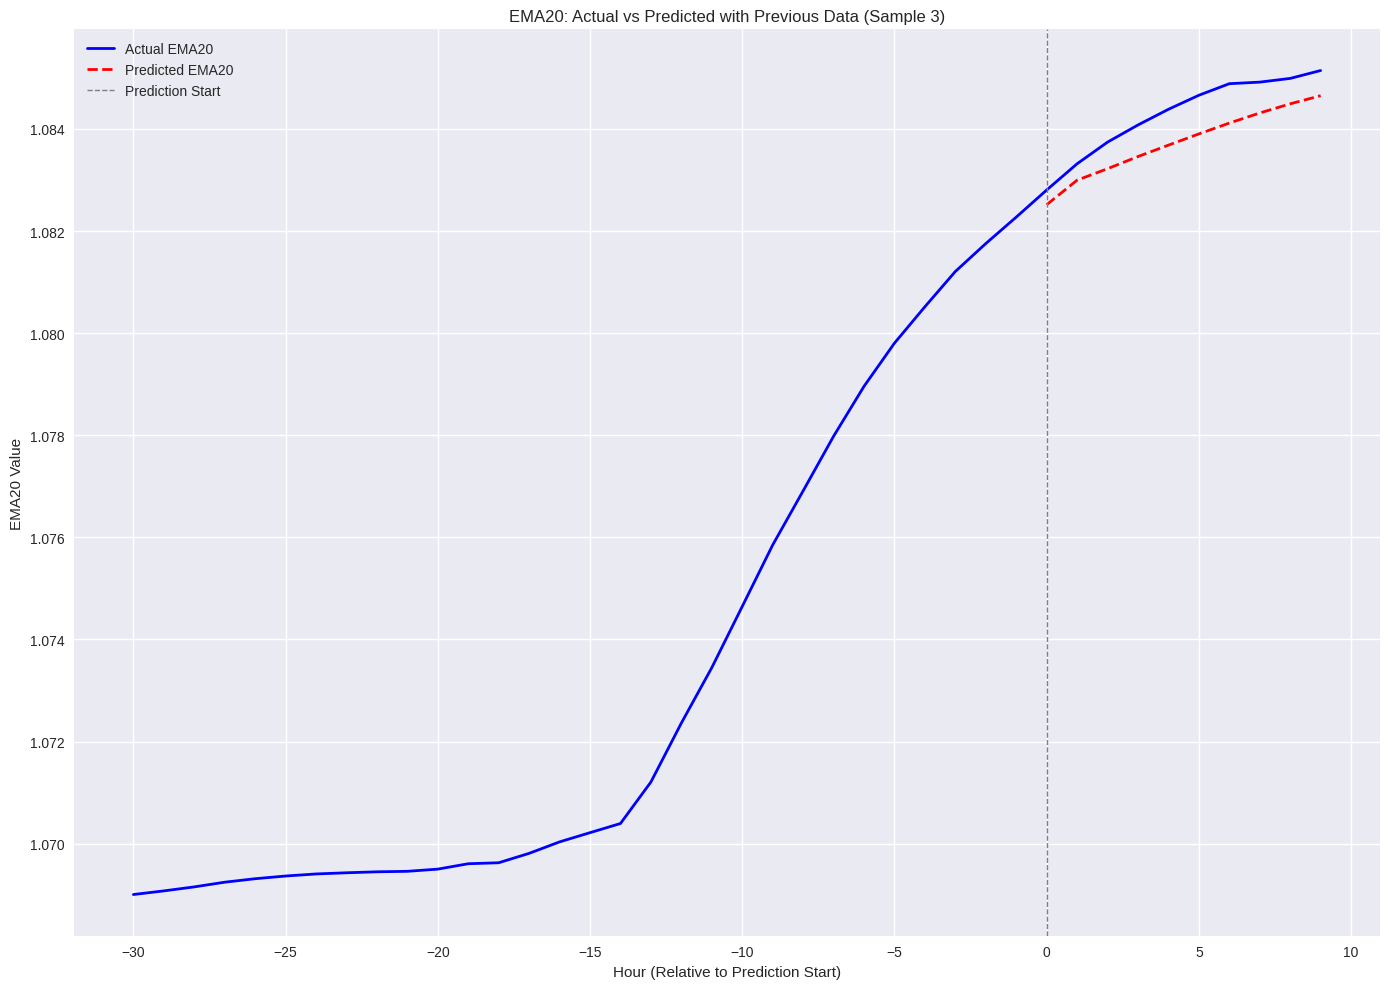

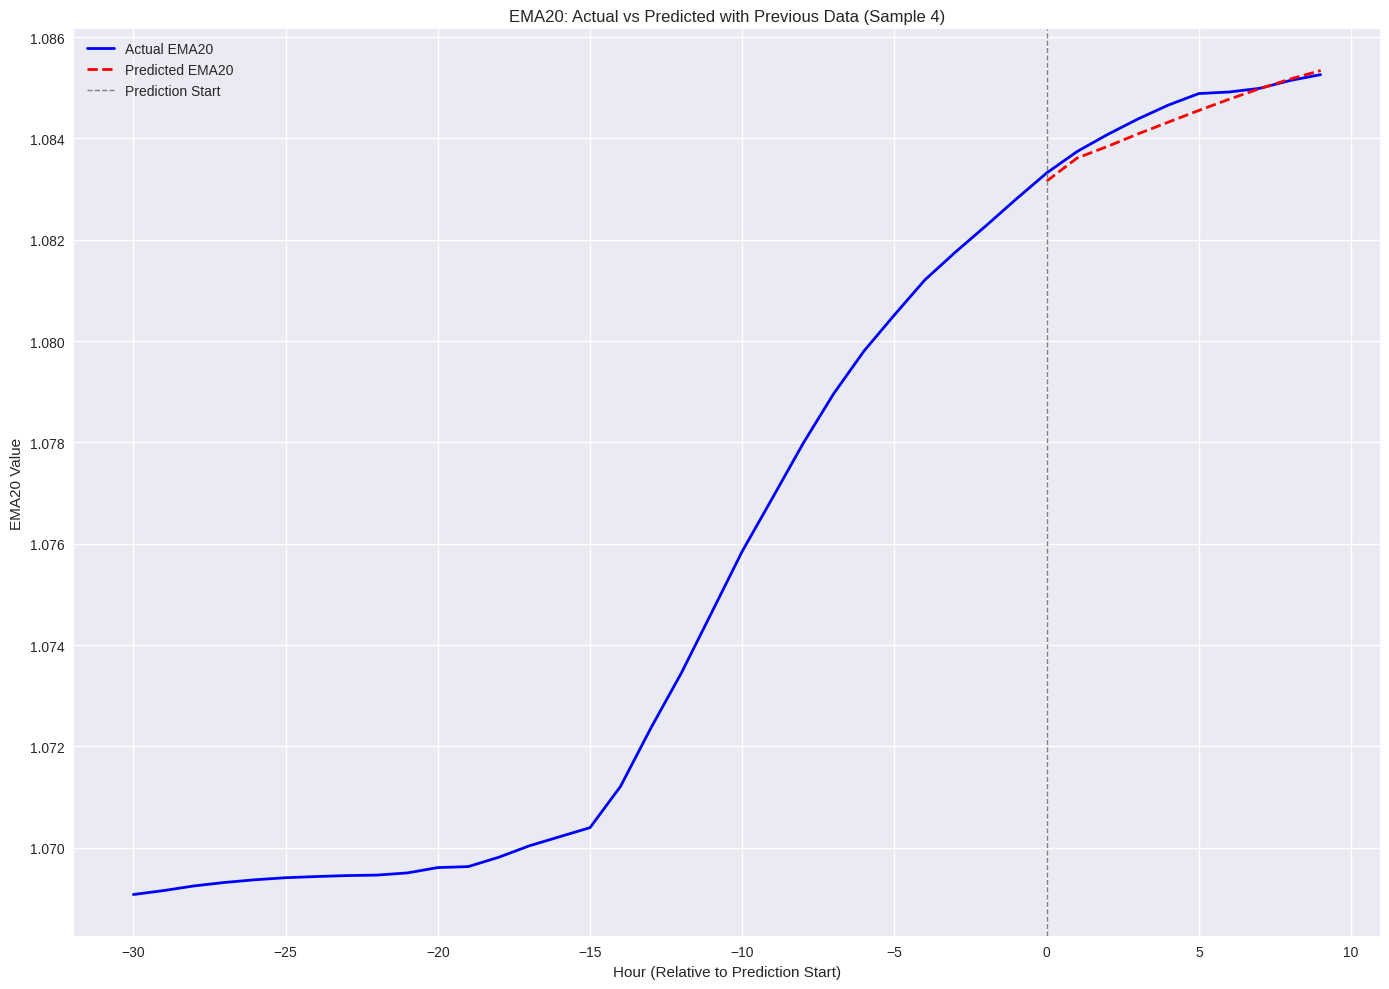

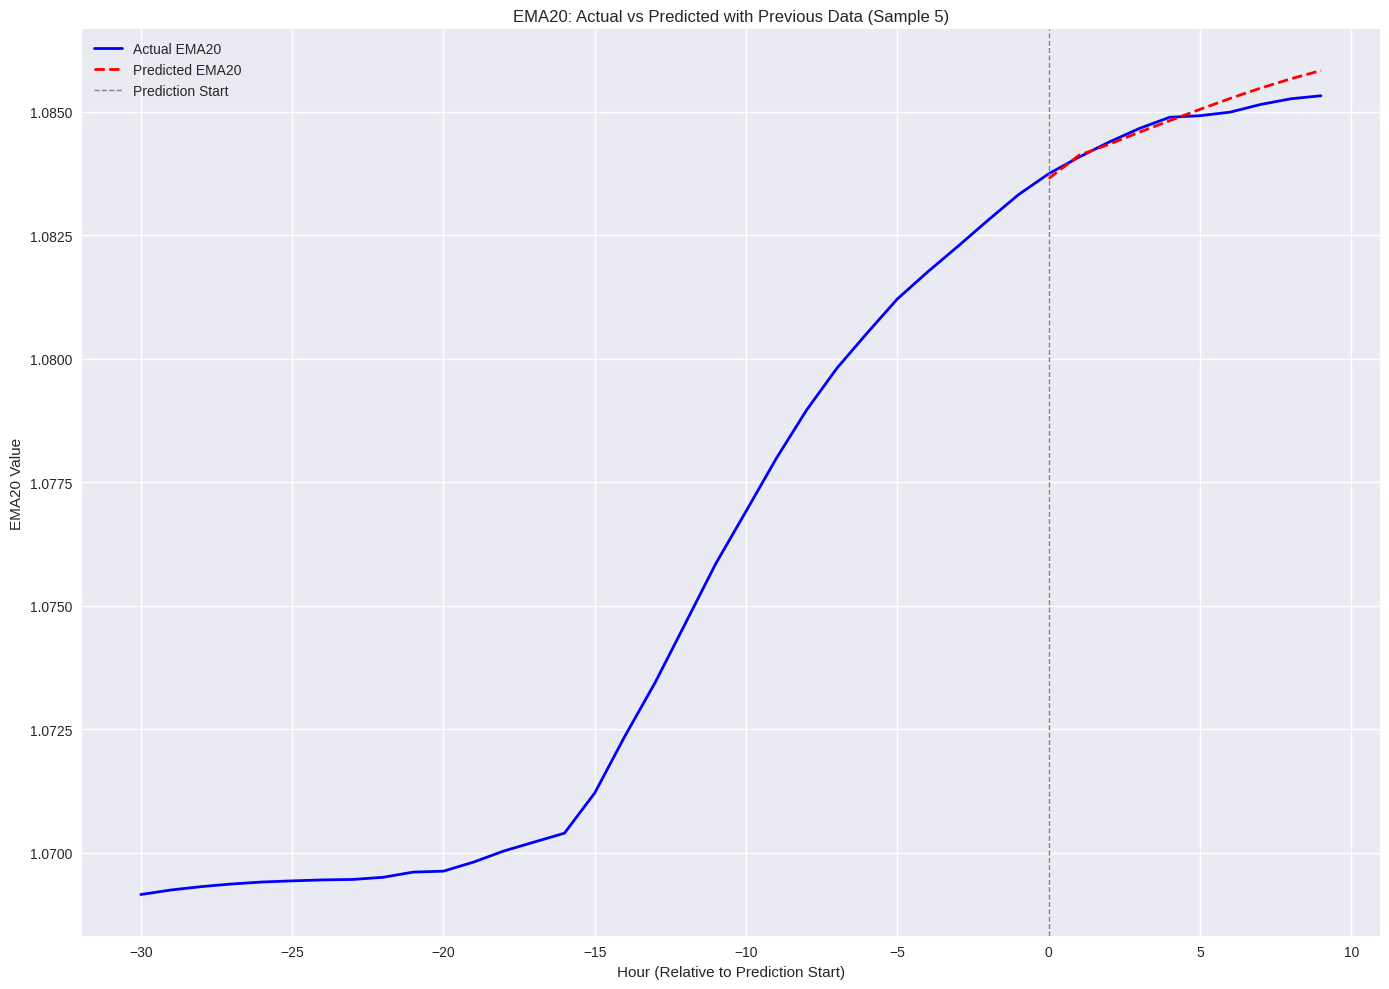

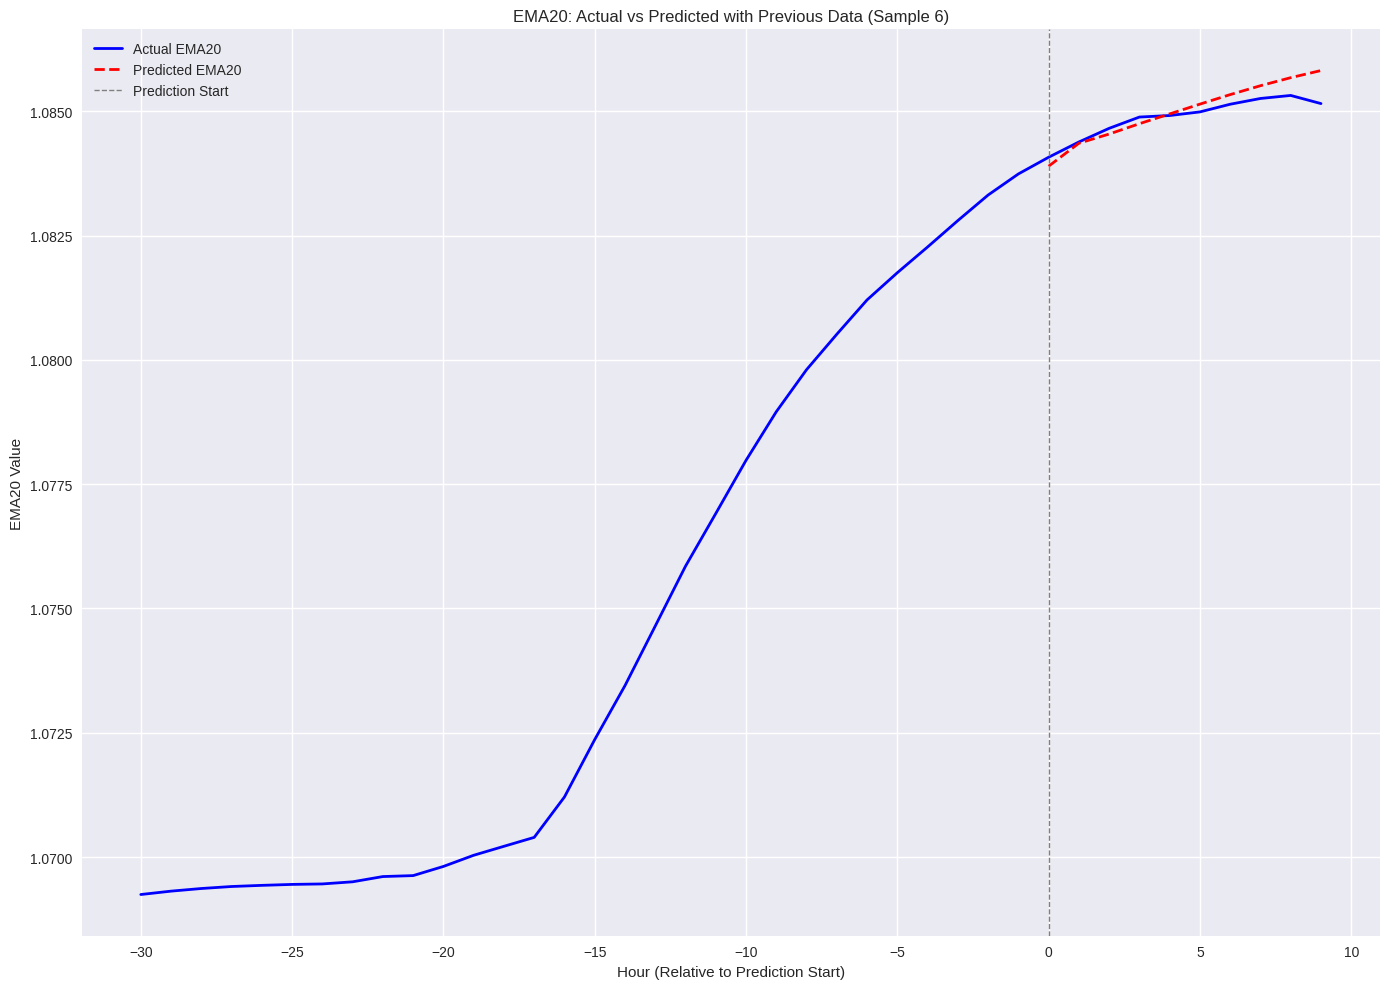

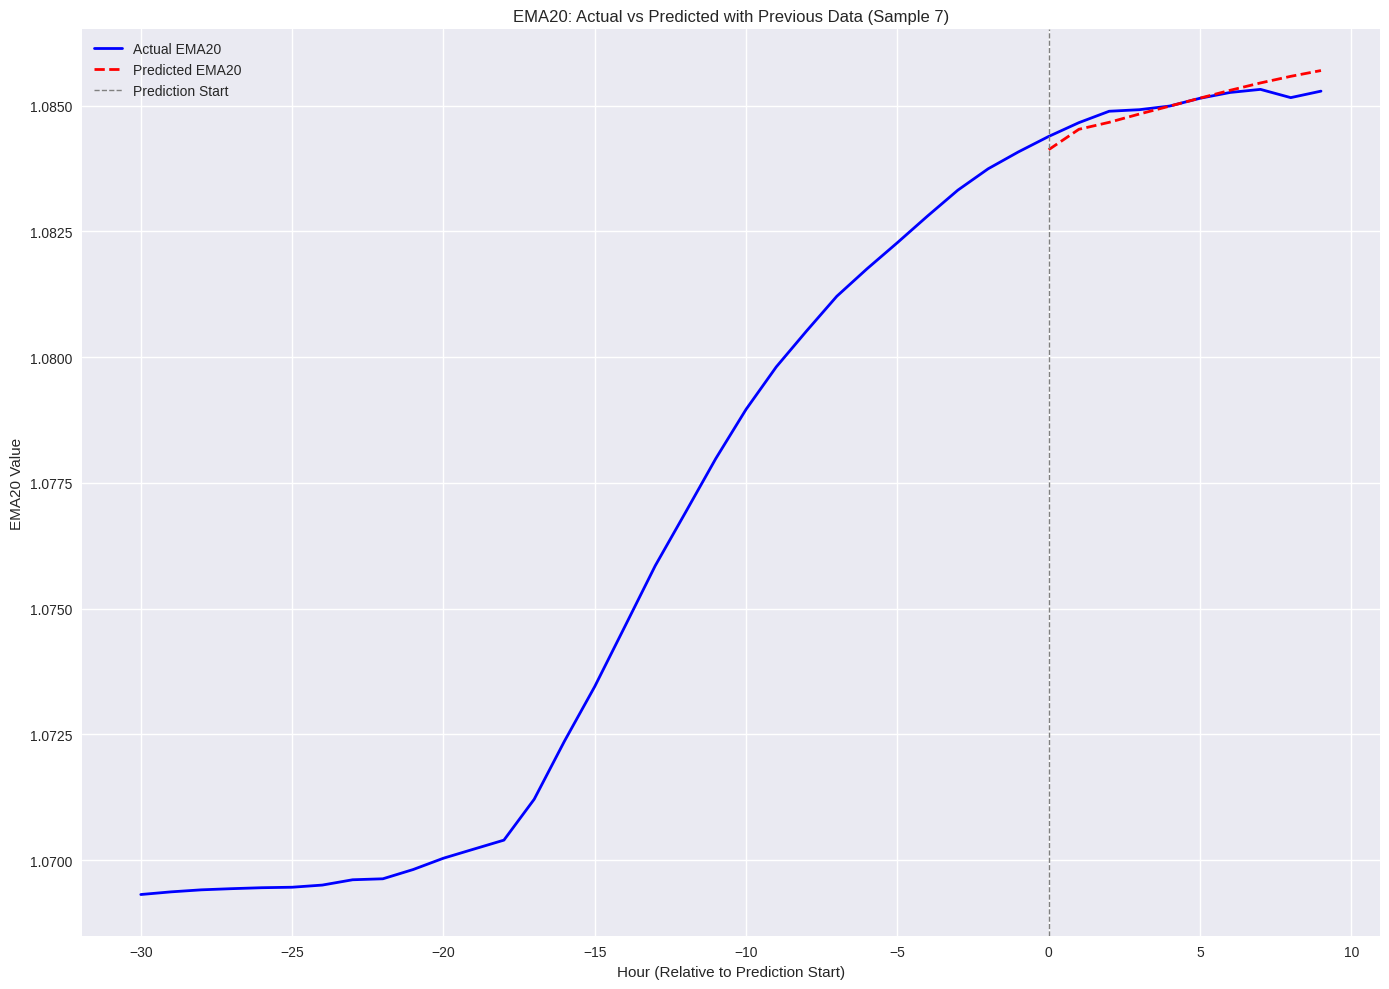

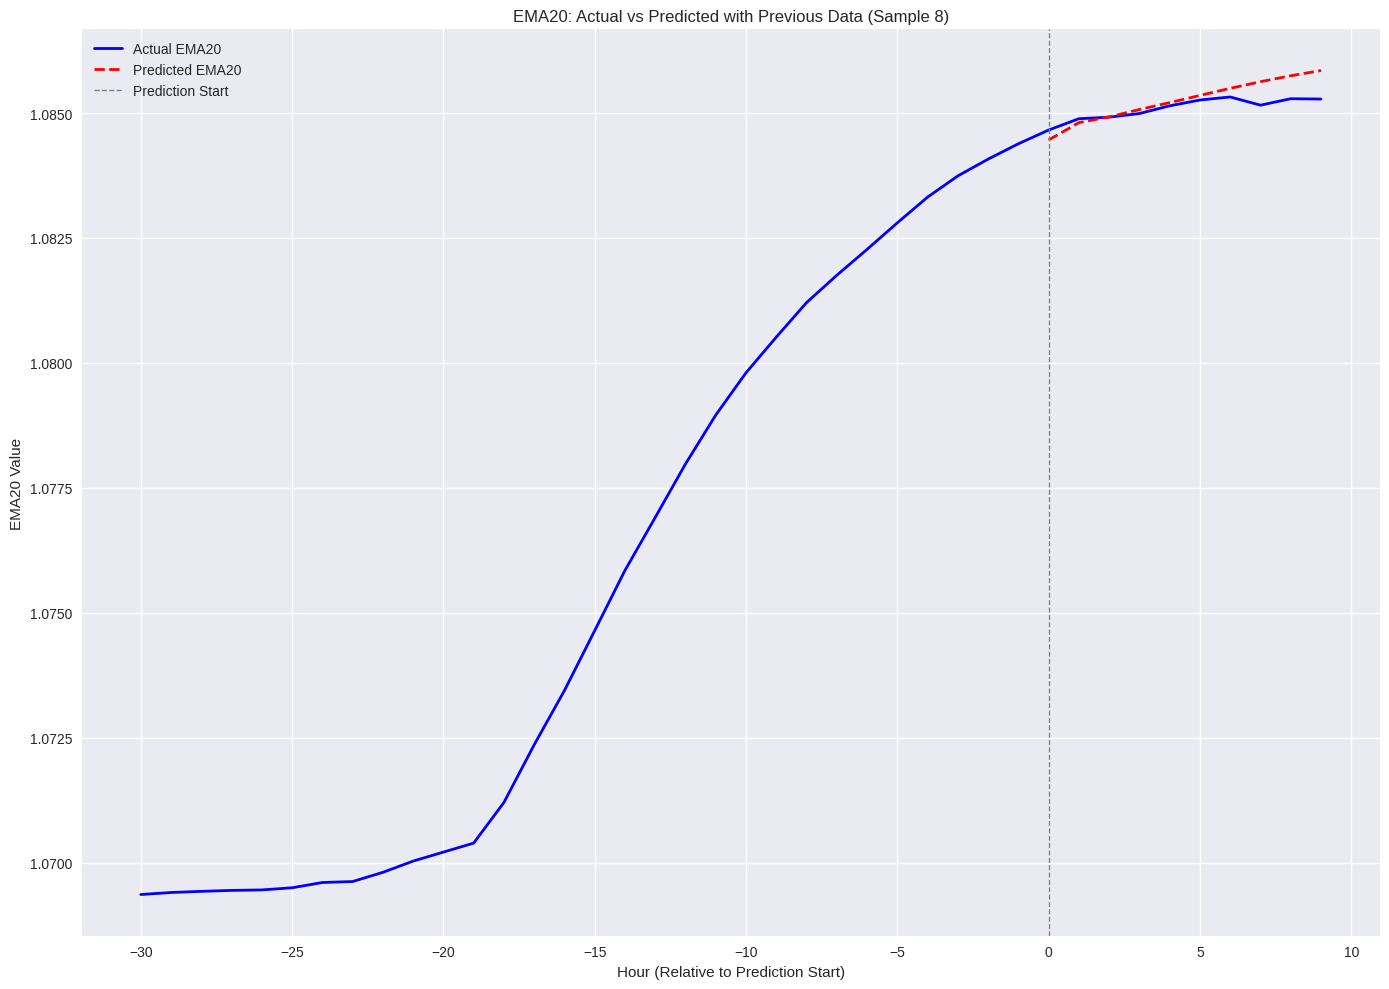

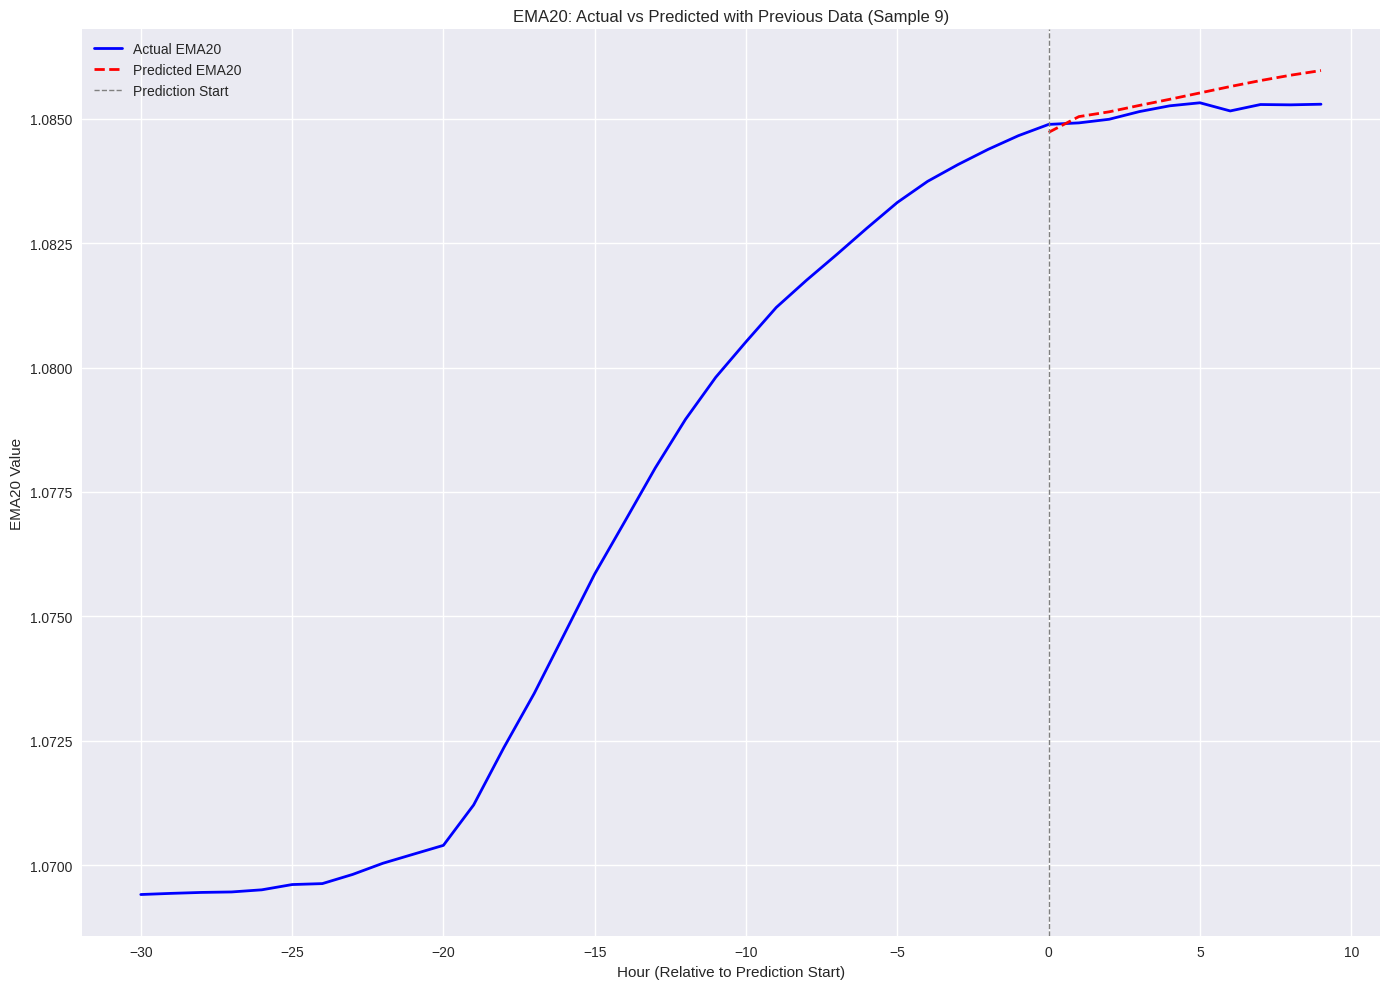

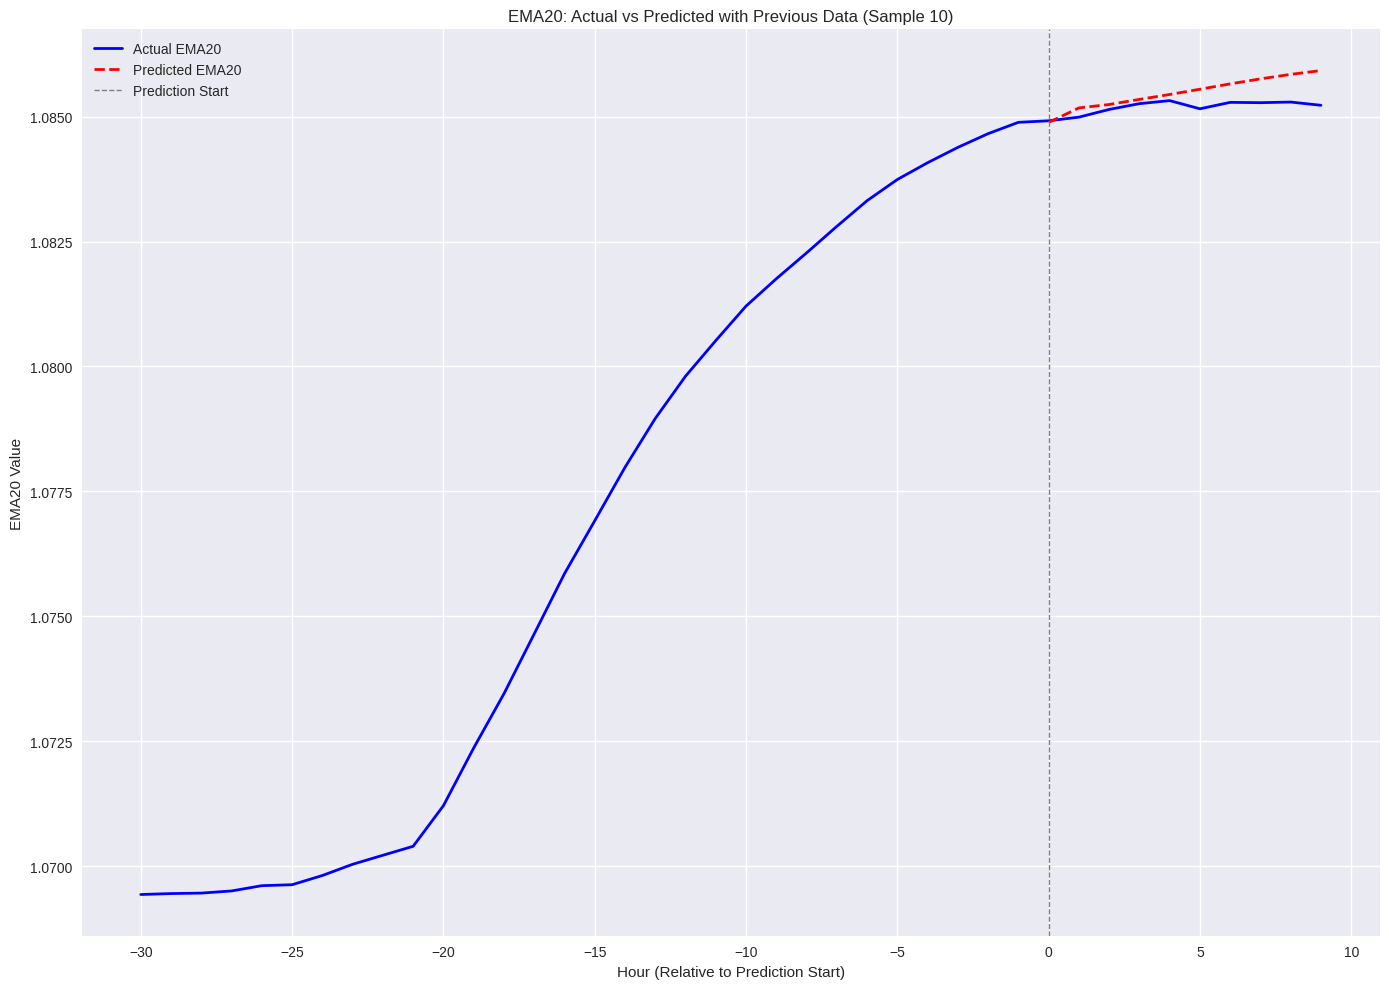

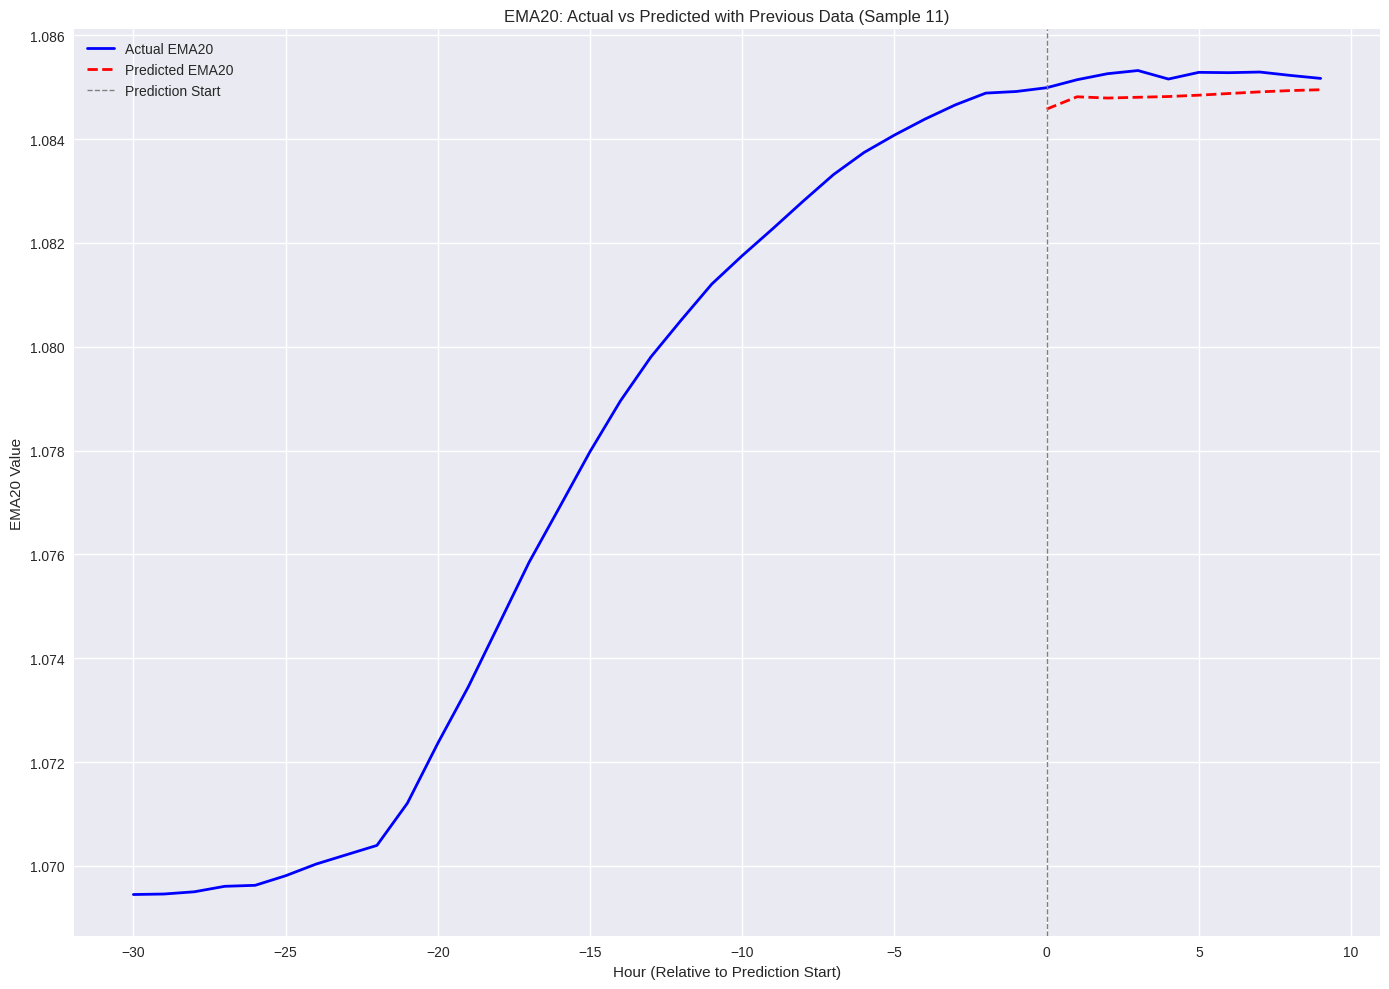

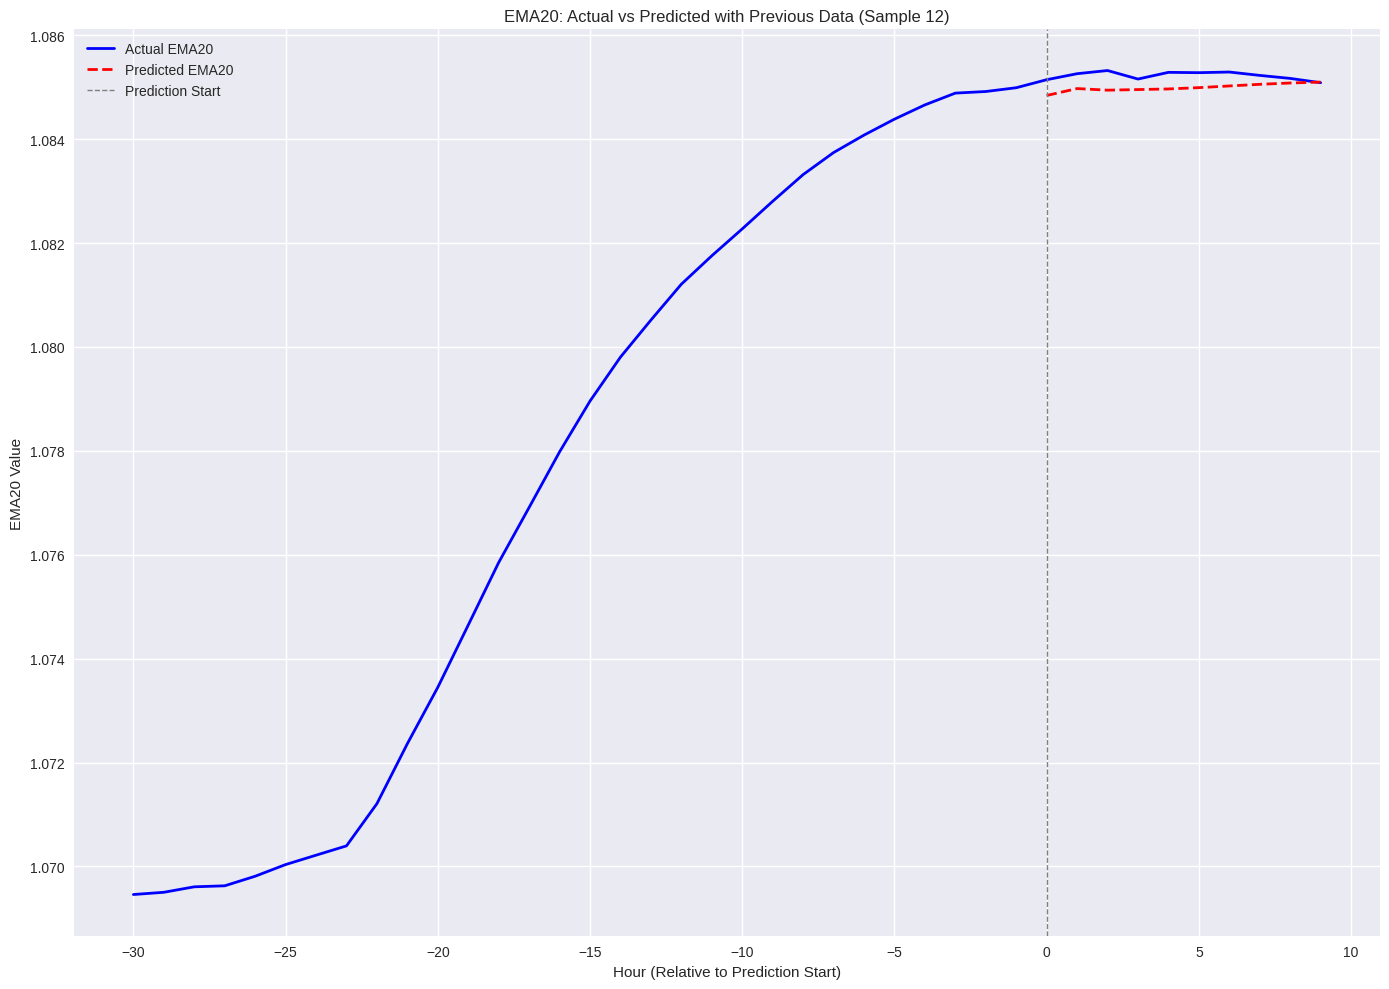

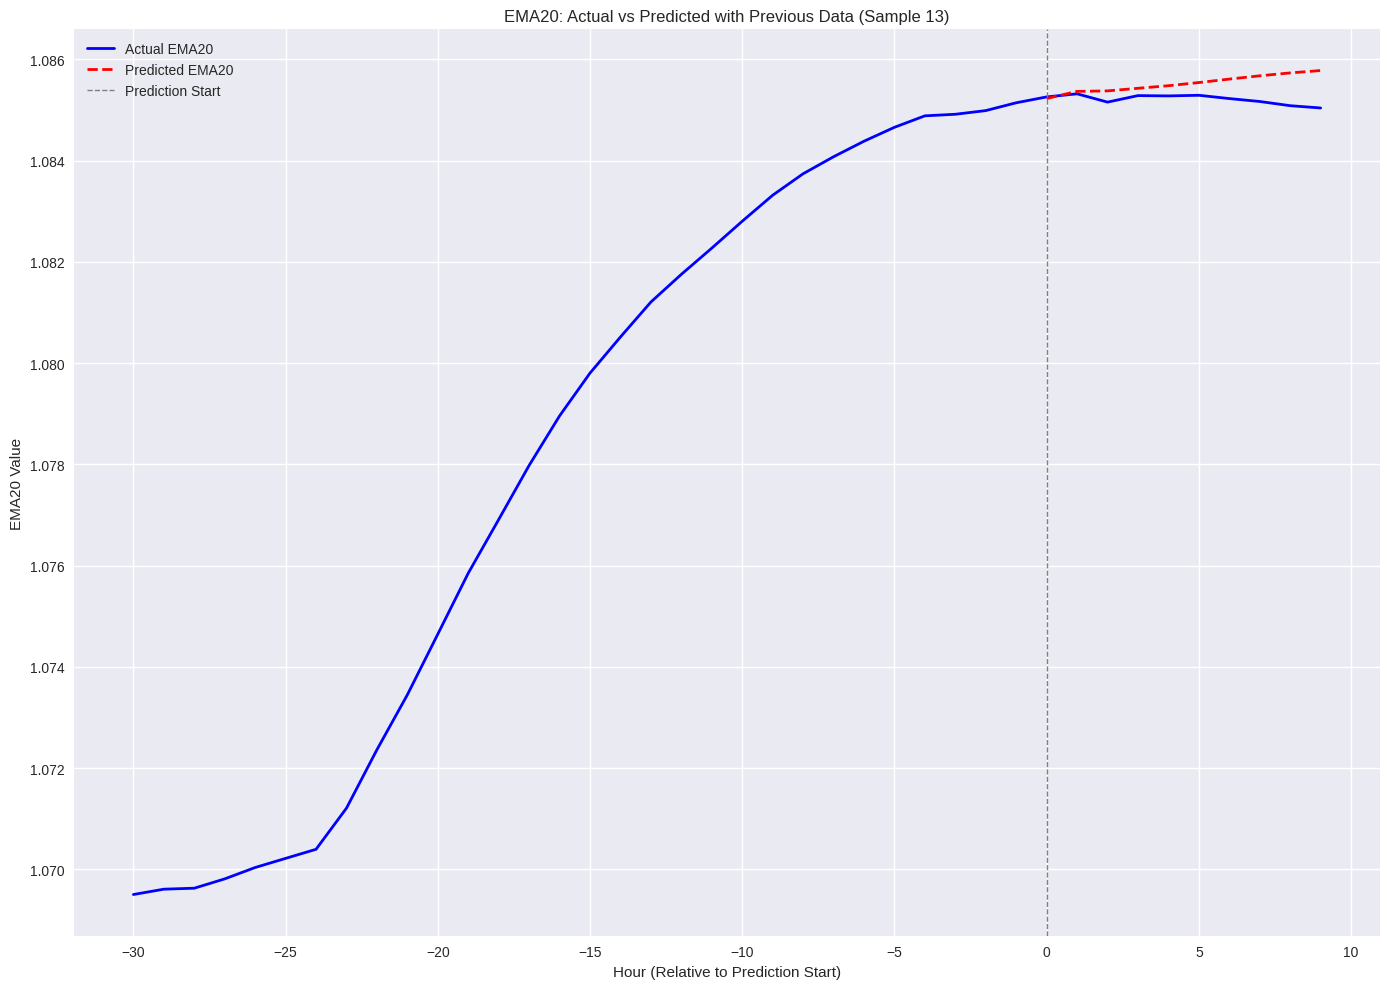

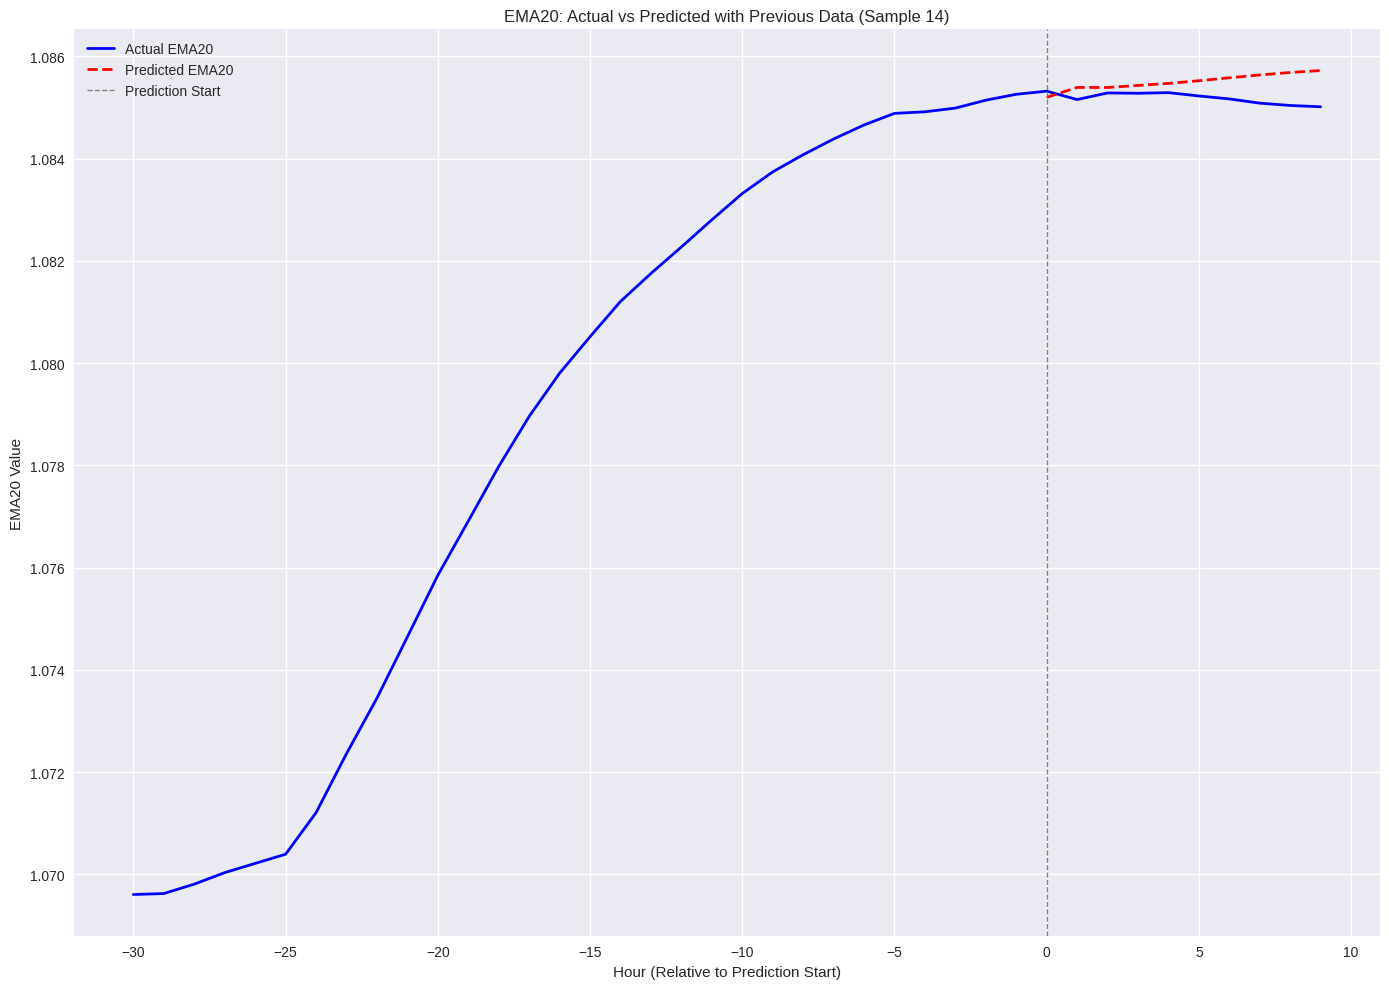

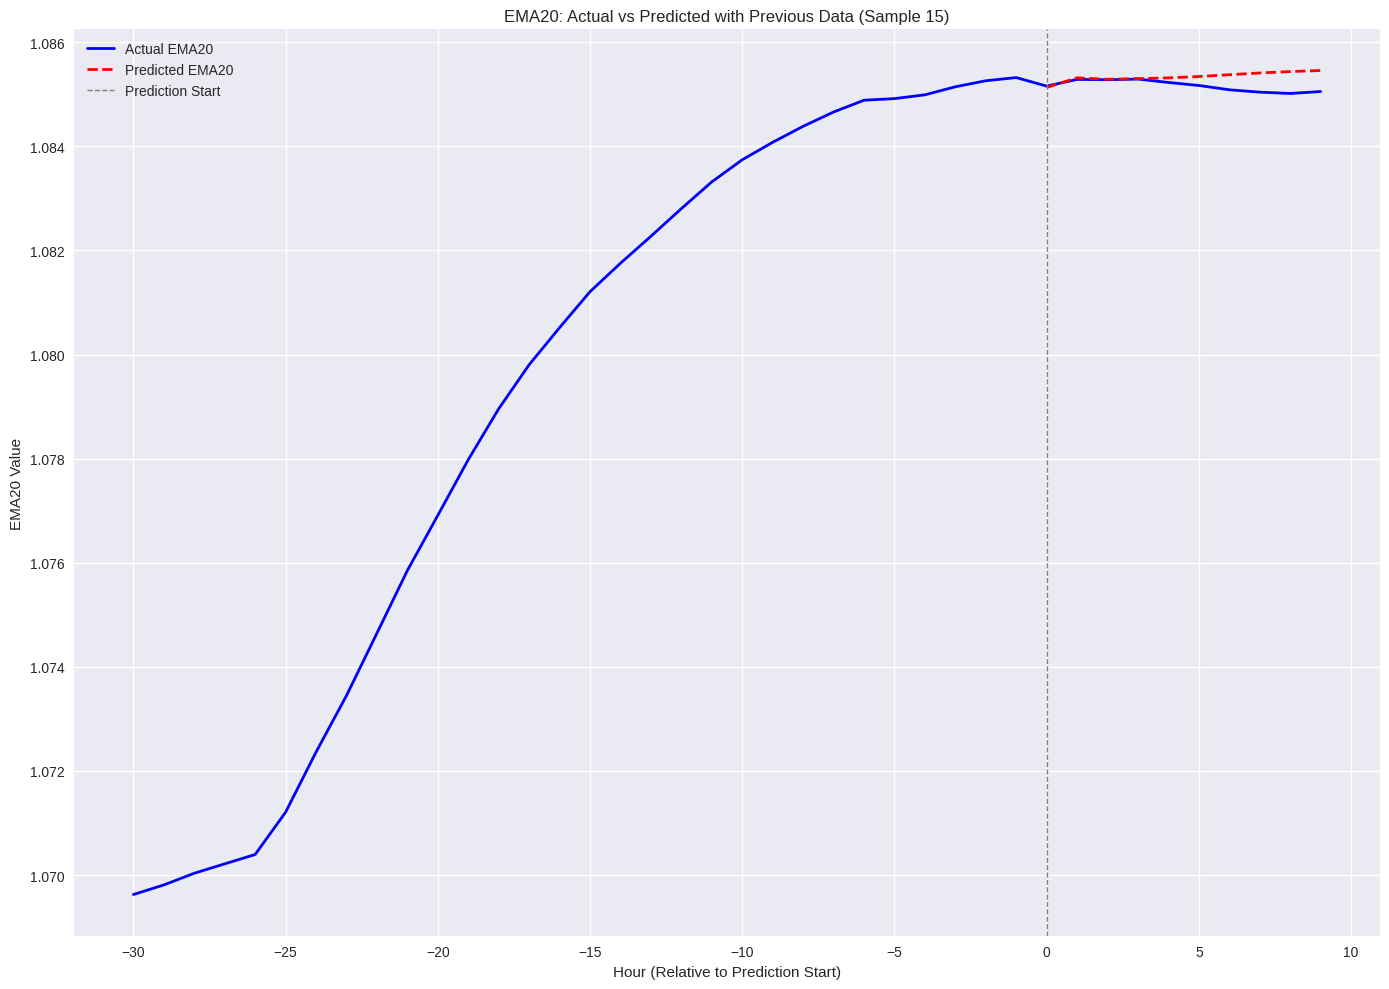

معیارهای دقت برای EMA20:
MSE: 0.000000
MAE: 0.000418


In [49]:
import matplotlib.pyplot as plt
import numpy as np

# تنظیمات ظاهری نمودار
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14, 10)

# تعداد نمونه‌ها برای نمایش
n_samples_to_plot = 15

# تعداد تایم‌استپ‌های قبلی که می‌خواهیم نشان دهیم
n_previous_steps = 30

# فرض می‌کنیم features=['Close', 'ema20', 'ema50'] است و ema20 در اندیس 1 قرار دارد
ema20_feature_idx = features.index('ema20')

# رسم نمودار برای EMA20
for sample_idx in range(min(n_samples_to_plot, y_test_rescaled.shape[0])):
    # استخراج 40 تایم‌استپ قبلی از X_test
    previous_data = X_test[sample_idx][-n_previous_steps:]  # 40 تایم‌استپ آخر از X_test[sample_idx]
    previous_data_rescaled = scaler_features.inverse_transform(previous_data)  # برگرداندن به مقادیر اصلی
    previous_ema20 = previous_data_rescaled[:, ema20_feature_idx]  # استخراج ema20

    # داده‌های واقعی و پیش‌بینی‌شده برای 24 تایم‌استپ بعدی
    actual_ema20_future = y_test_rescaled[sample_idx, :, 0]  # EMA20 واقعی (24 تایم‌استپ)
    pred_ema20 = y_pred_rescaled[sample_idx, :, 0]          # EMA20 پیش‌بینی‌شده (24 تایم‌استپ)

    # ترکیب 40 تایم‌استپ قبلی (واقعی) با 24 تایم‌استپ بعدی (واقعی)
    actual_ema20 = np.concatenate([previous_ema20, actual_ema20_future])

    # ایجاد بازه زمانی برای محور x
    time_steps = np.arange(-n_previous_steps, len(actual_ema20_future))

    # ایجاد نمودار
    plt.figure()

    # رسم EMA20 واقعی (40 تایم‌استپ قبلی + 24 تایم‌استپ بعدی)
    plt.plot(time_steps, actual_ema20, label='Actual EMA20', color='blue', linewidth=2)

    # رسم EMA20 پیش‌بینی‌شده (فقط برای 24 تایم‌استپ بعدی)
    plt.plot(time_steps[n_previous_steps:], pred_ema20, label='Predicted EMA20', color='red', linestyle='--', linewidth=2)

    # خط عمودی برای جدا کردن داده‌های قبلی و پیش‌بینی
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, label='Prediction Start')

    # تنظیمات نمودار
    plt.title(f'EMA20: Actual vs Predicted with Previous Data (Sample {sample_idx + 1})')
    plt.xlabel('Hour (Relative to Prediction Start)')
    plt.ylabel('EMA20 Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# محاسبه و نمایش معیارهای دقت (MSE و MAE)
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_ema20 = mean_squared_error(y_test_rescaled[:, :, 0].flatten(), y_pred_rescaled[:, :, 0].flatten())
mae_ema20 = mean_absolute_error(y_test_rescaled[:, :, 0].flatten(), y_pred_rescaled[:, :, 0].flatten())

print("معیارهای دقت برای EMA20:")
print(f"MSE: {mse_ema20:.6f}")
print(f"MAE: {mae_ema20:.6f}")

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# تنظیمات ظاهری نمودار
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14, 10)

# انتخاب تعداد نمونه‌ها برای نمایش (مثلاً 5 سری پیش‌بینی)
n_samples_to_plot = 5

# رسم نمودار برای EMA20 و EMA50
for sample_idx in range(min(n_samples_to_plot, y_test_rescaled.shape[0])):
    # داده‌های واقعی و پیش‌بینی‌شده برای نمونه خاص
    actual_ema20 = y_test_rescaled[sample_idx, :, 0]  # EMA20 واقعی
    actual_ema50 = y_test_rescaled[sample_idx, :, 1]  # EMA50 واقعی
    pred_ema20 = y_pred_rescaled[sample_idx, :, 0]    # EMA20 پیش‌بینی‌شده
    pred_ema50 = y_pred_rescaled[sample_idx, :, 1]    # EMA50 پیش‌بینی‌شده
    
    # ایجاد نمودار
    plt.figure()
    
    # نمودار برای EMA20
    plt.subplot(2, 1, 1)
    plt.plot(actual_ema20, label='Actual EMA20', color='blue', linewidth=2)
    plt.plot(pred_ema20, label='Predicted EMA20', color='lightblue', linestyle='--', linewidth=2)
    plt.title(f'EMA20: Actual vs Predicted (Sample {sample_idx + 1})')
    plt.xlabel('Hour')
    plt.ylabel('EMA20 Value')
    plt.legend()
    plt.grid(True)
    
    # نمودار برای EMA50
    plt.subplot(2, 1, 2)
    plt.plot(actual_ema50, label='Actual EMA50', color='green', linewidth=2)
    plt.plot(pred_ema50, label='Predicted EMA50', color='lightgreen', linestyle='--', linewidth=2)
    plt.title(f'EMA50: Actual vs Predicted (Sample {sample_idx + 1})')
    plt.xlabel('Hour')
    plt.ylabel('EMA50 Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# محاسبه و نمایش معیارهای دقت (MSE و MAE)
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_ema20 = mean_squared_error(y_test_rescaled[:, :, 0].flatten(), y_pred_rescaled[:, :, 0].flatten())
mae_ema20 = mean_absolute_error(y_test_rescaled[:, :, 0].flatten(), y_pred_rescaled[:, :, 0].flatten())
mse_ema50 = mean_squared_error(y_test_rescaled[:, :, 1].flatten(), y_pred_rescaled[:, :, 1].flatten())
mae_ema50 = mean_absolute_error(y_test_rescaled[:, :, 1].flatten(), y_pred_rescaled[:, :, 1].flatten())

print("معیارهای دقت برای EMA20:")
print(f"MSE: {mse_ema20:.6f}")
print(f"MAE: {mae_ema20:.6f}")
print("\nمعیارهای دقت برای EMA50:")
print(f"MSE: {mse_ema50:.6f}")
print(f"MAE: {mae_ema50:.6f}")

/tmp/ipykernel_31/4201925820.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


IndexError: index 1 is out of bounds for axis 2 with size 1

In [51]:
forecast_ema20 = []
# forecast_ema50 = []
forecast_ema20.extend(y_pred_rescaled[0, :, 0])
# forecast_ema50.extend(y_pred_rescaled[0, :, 1])
for i in range(1, y_pred_rescaled.shape[0]):
    forecast_ema20.append(y_pred_rescaled[i, -1, 0])
    # forecast_ema50.append(y_pred_rescaled[i, -1, 1])

# داده‌های واقعی
total_timesteps = len(forecast_ema20)
start_idx = len(data) - total_timesteps
actual_ema20 = data['ema20'].values[start_idx:start_idx + total_timesteps]


/tmp/ipykernel_31/1584108878.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


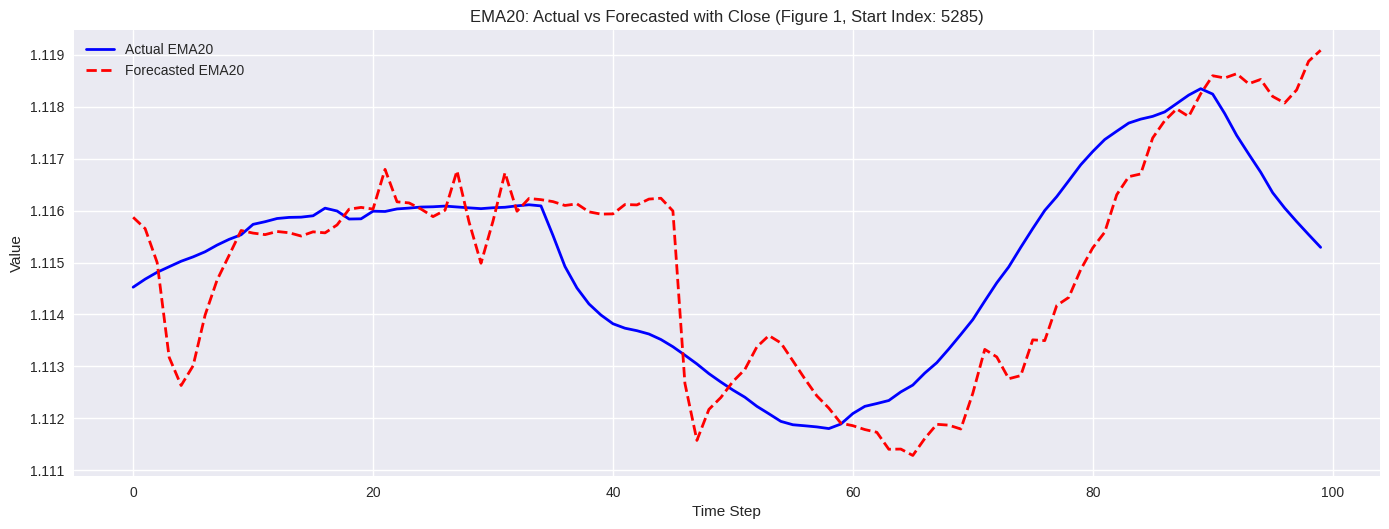

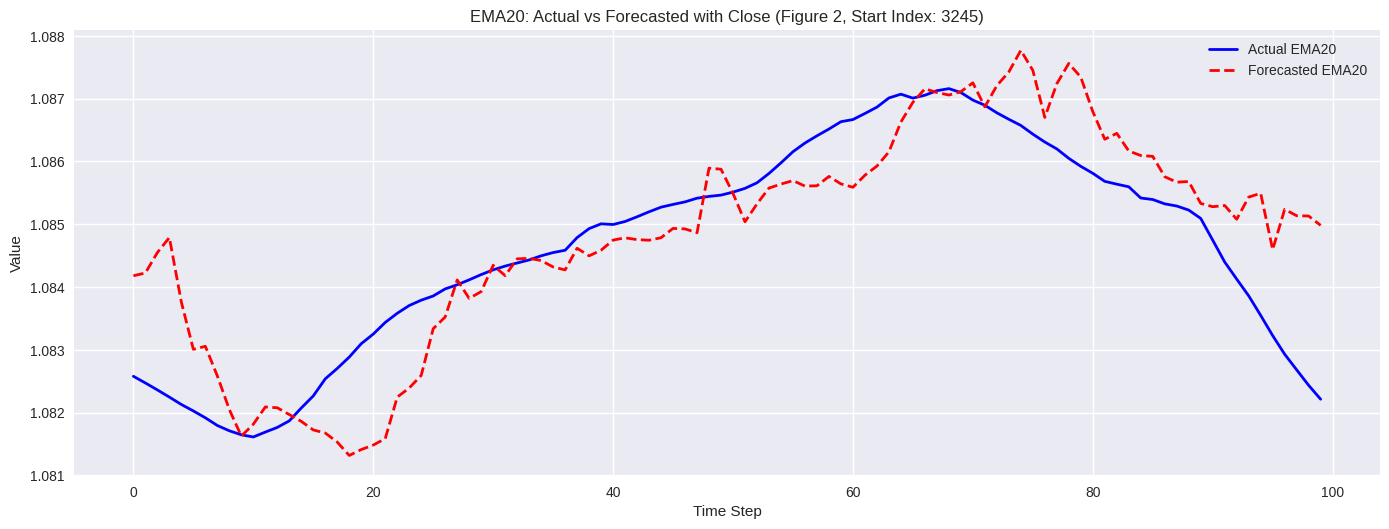

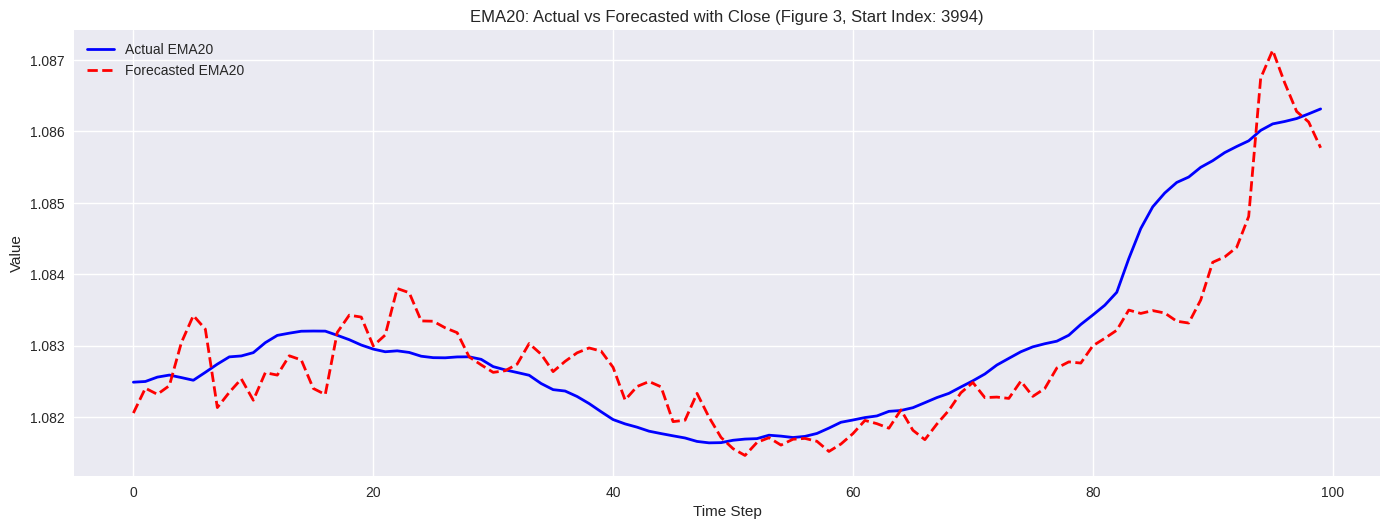

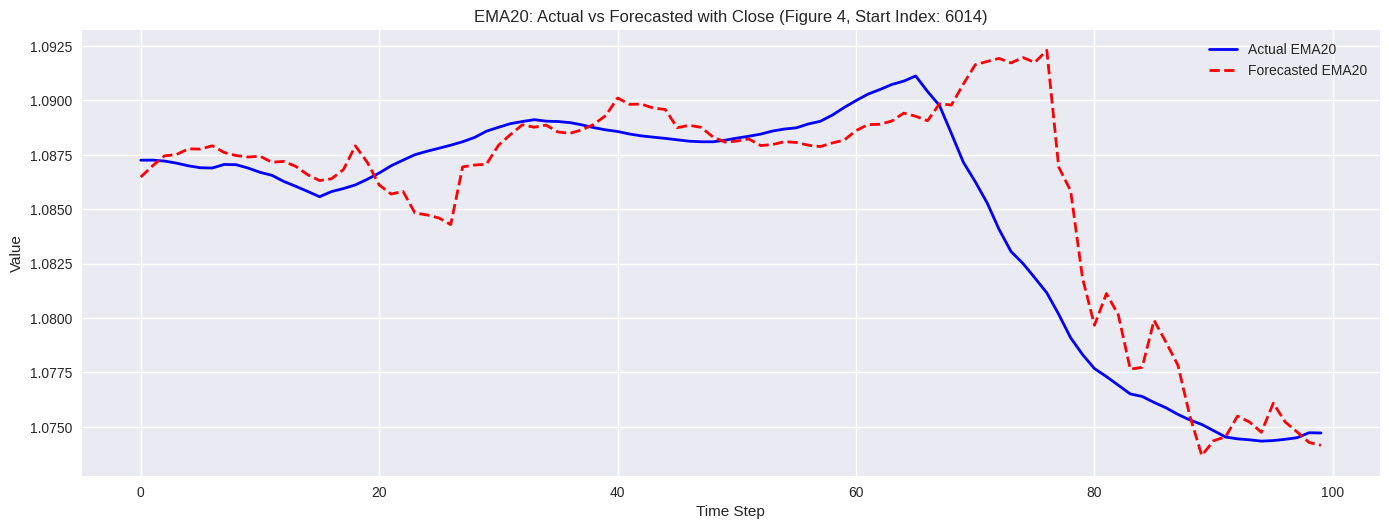

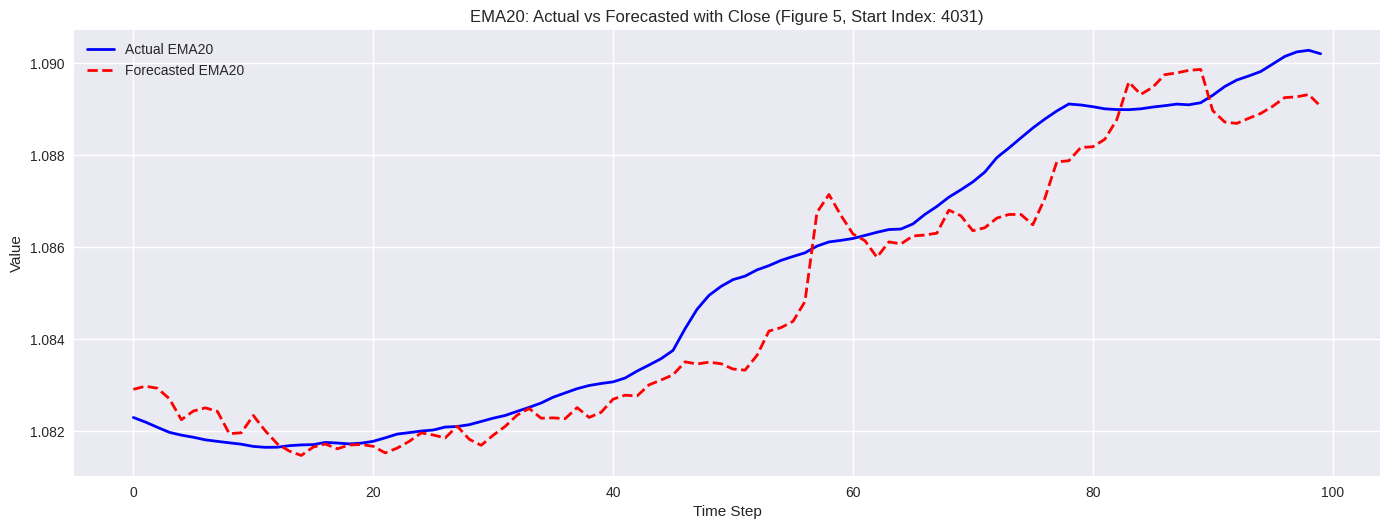

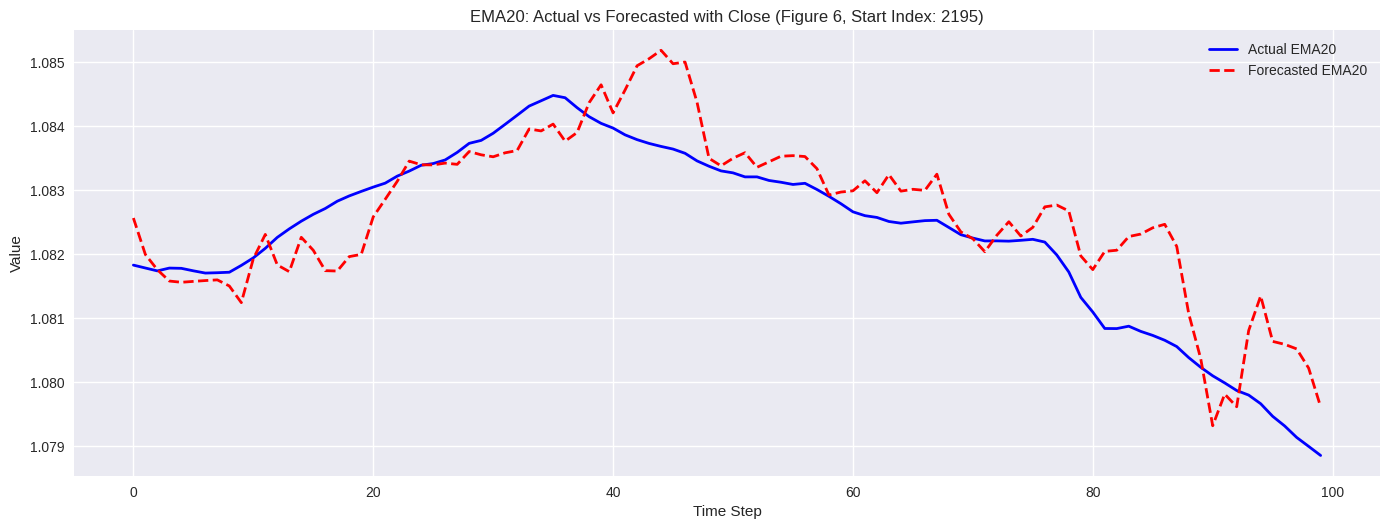

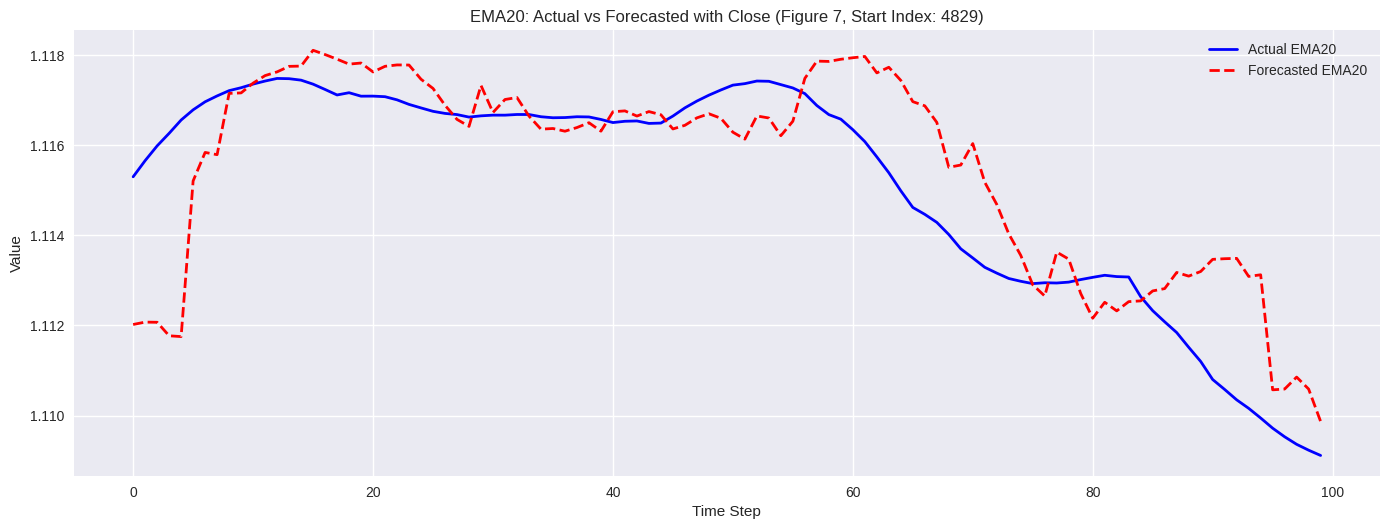

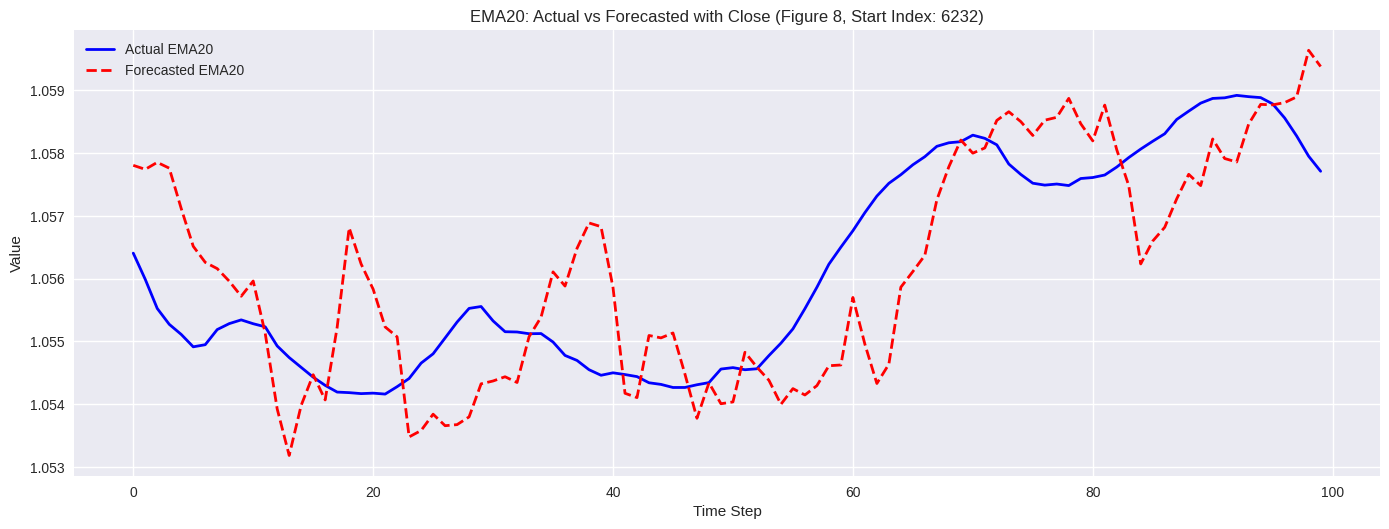

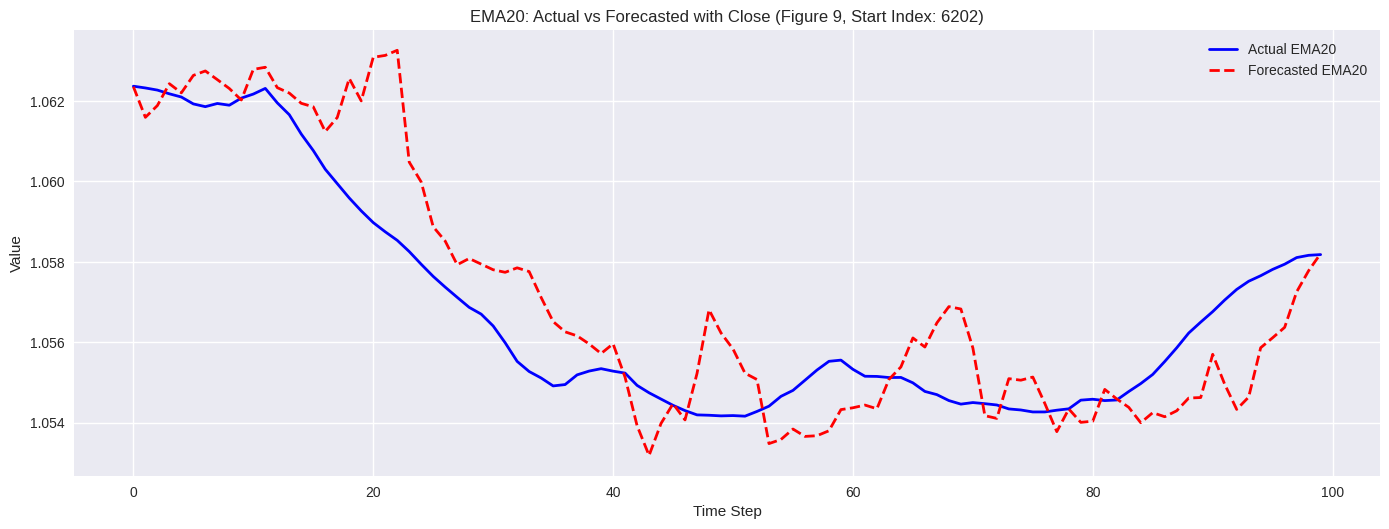

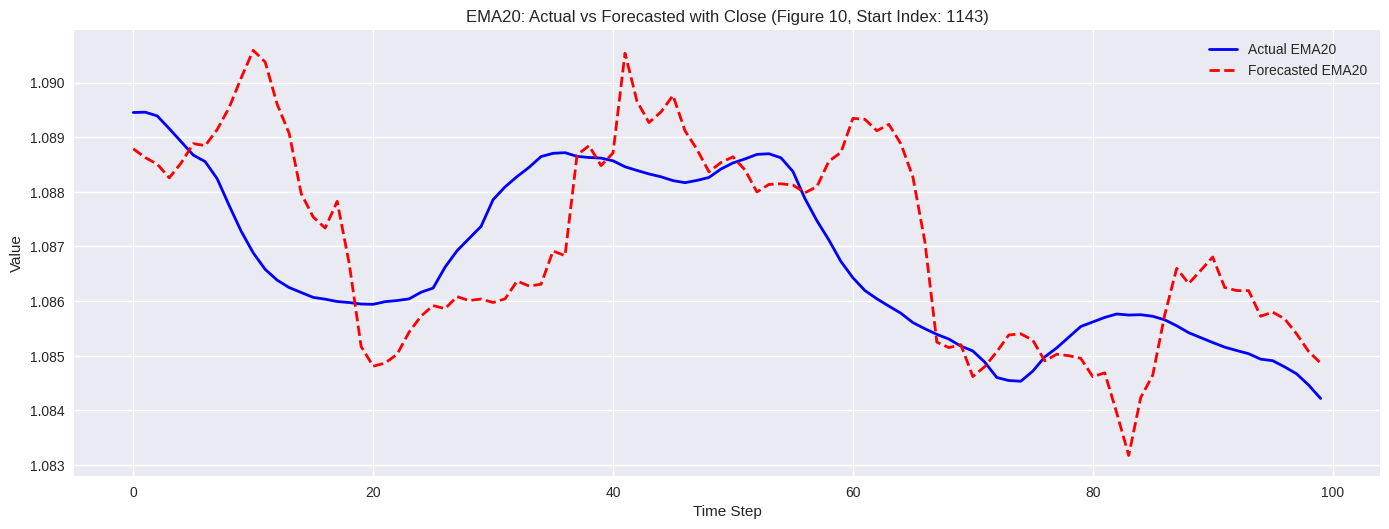

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# تنظیمات ظاهری نمودار
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14, 10)

# فرض می‌کنیم داده‌ها آماده هستند
# actual_ema20, actual_ema50, forecast_ema20, forecast_ema50, close_values
total_samples = len(actual_ema20)  # تعداد کل نمونه‌ها
samples_per_figure = 100  # تعداد نمونه‌ها در هر فیگور
num_figures = 10  # تعداد فیگورها

# محاسبه حداکثر نقطه شروع ممکن
# نقطه شروع باید طوری باشد که 100 نمونه متوالی بعد از آن در داده‌ها وجود داشته باشد
max_start_idx = total_samples - samples_per_figure

# انتخاب تصادفی نقاط شروع برای هر دسته
start_indices = np.random.choice(max_start_idx, size=num_figures, replace=False)

# رسم 10 فیگور
for fig_idx, start_idx in enumerate(start_indices):
    # انتخاب بازه 100 تایی متوالی
    indices = np.arange(start_idx, start_idx + samples_per_figure)
    
    # انتخاب داده‌ها برای این فیگور
    actual_ema20_subset = actual_ema20[indices]
    # actual_ema50_subset = actual_ema50[indices]
    forecast_ema20_subset = np.array(forecast_ema20)[indices]
    # forecast_ema50_subset = np.array(forecast_ema50)[indices]
    close_subset = close_values[indices]

    # رسم فیگور
    plt.figure()
    
    # EMA20
    plt.subplot(2, 1, 1)
    plt.plot(actual_ema20_subset, label='Actual EMA20', color='blue', linewidth=2)
    plt.plot(forecast_ema20_subset, label='Forecasted EMA20', color='red', linestyle='--', linewidth=2)
    plt.title(f'EMA20: Actual vs Forecasted with Close (Figure {fig_idx + 1}, Start Index: {start_idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

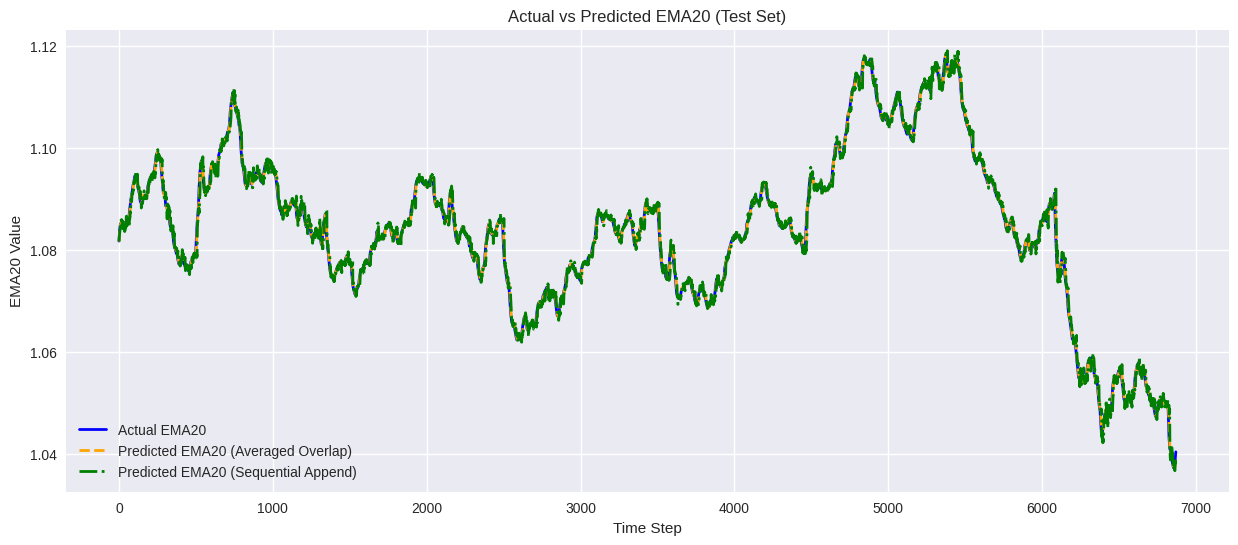

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# فرض می‌کنیم data, X_test, y_pred, scaler_target از اجرای کد قبلی در دسترس هستند
# پارامترها
seq_length = 72
future_steps = 10

# 1. استخراج سری زمانی واقعی EMA20 برای بازه تست
test_start_idx = len(data) - len(X_test) - future_steps  # شروع بازه تست
test_end_idx = len(data)  # پایان بازه تست
actual_ema20 = data['ema20'].values[test_start_idx:test_end_idx]

# 2. معکوس کردن نرمال‌سازی پیش‌بینی‌ها
y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(-1, future_steps))  # پیش‌بینی‌ها برای هر دنباله

# 3. راهبرد اول: میانگین‌گیری با در نظر گرفتن هم‌پوشانی
n_test_samples = len(X_test)  # تعداد دنباله‌های تست
pred_length = n_test_samples + future_steps - 1  # طول کل بازه پیش‌بینی
pred_avg = np.zeros(pred_length)  # آرایه برای ذخیره میانگین‌ها
counts = np.zeros(pred_length)  # آرایه برای شمارش تعداد پیش‌بینی‌ها برای هر نقطه

# پر کردن مقادیر پیش‌بینی
for i in range(n_test_samples):
    for j in range(future_steps):
        pred_idx = i + j
        pred_avg[pred_idx] += y_pred_inv[i, j]
        counts[pred_idx] += 1

# محاسبه میانگین
pred_avg = pred_avg / counts

# 4. راهبرد دوم: استفاده از پیش‌بینی نمونه اول برای 10 گام اول، سپس الحاق آخرین پیش‌بینی‌ها
pred_sequential = []

# گام‌های 72 تا 81: استفاده از پیش‌بینی نمونه اول (y_pred[0])
if n_test_samples > 0:
    pred_sequential.extend(y_pred_inv[0])  # 10 مقدار اول از نمونه اول

# از گام 82 به بعد: الحاق آخرین پیش‌بینی هر نمونه
for i in range(1, n_test_samples):
    last_pred = y_pred_inv[i, -1]  # آخرین گام پیش‌بینی (گام 10ام)
    pred_sequential.append(last_pred)

# تبدیل به آرایه numpy
pred_sequential = np.array(pred_sequential)

# 5. تنظیم طول‌ها برای رسم
min_length = min(len(actual_ema20), len(pred_avg), len(pred_sequential))
actual_ema20 = actual_ema20[:min_length]
pred_avg = pred_avg[:min_length]
pred_sequential = pred_sequential[:min_length]

# 6. رسم نمودار
plt.figure(figsize=(15, 6))
plt.plot(actual_ema20, label='Actual EMA20', color='blue', linewidth=2)
plt.plot(pred_avg, label='Predicted EMA20 (Averaged Overlap)', color='orange', linestyle='--', linewidth=2)
plt.plot(pred_sequential, label='Predicted EMA20 (Sequential Append)', color='green', linestyle='-.', linewidth=2)
plt.title('Actual vs Predicted EMA20 (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('EMA20 Value')
plt.legend()
plt.grid(True)
plt.show()

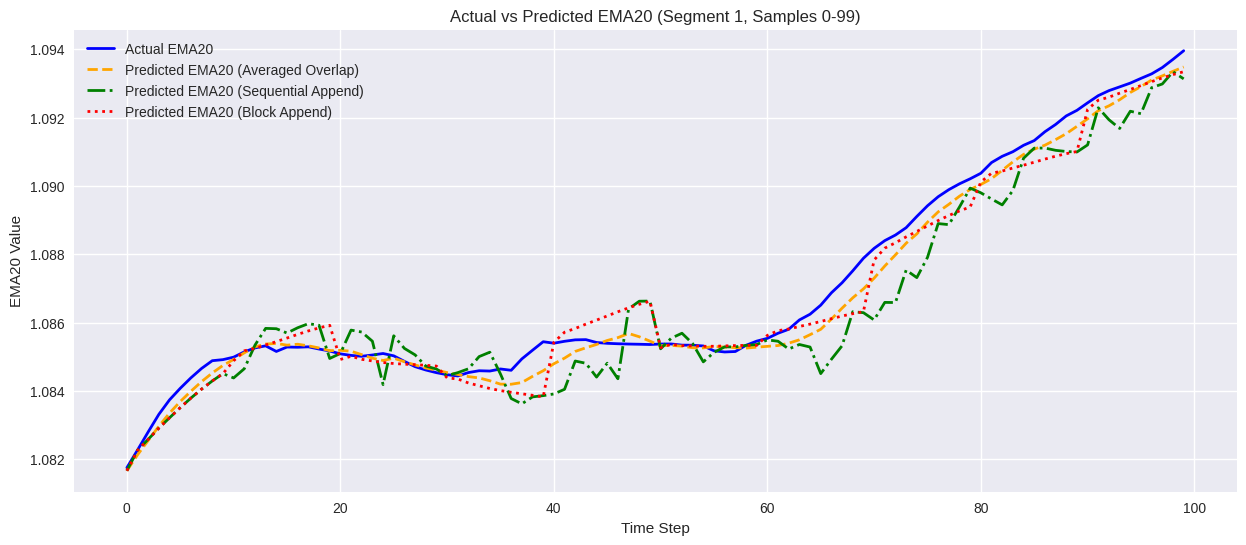

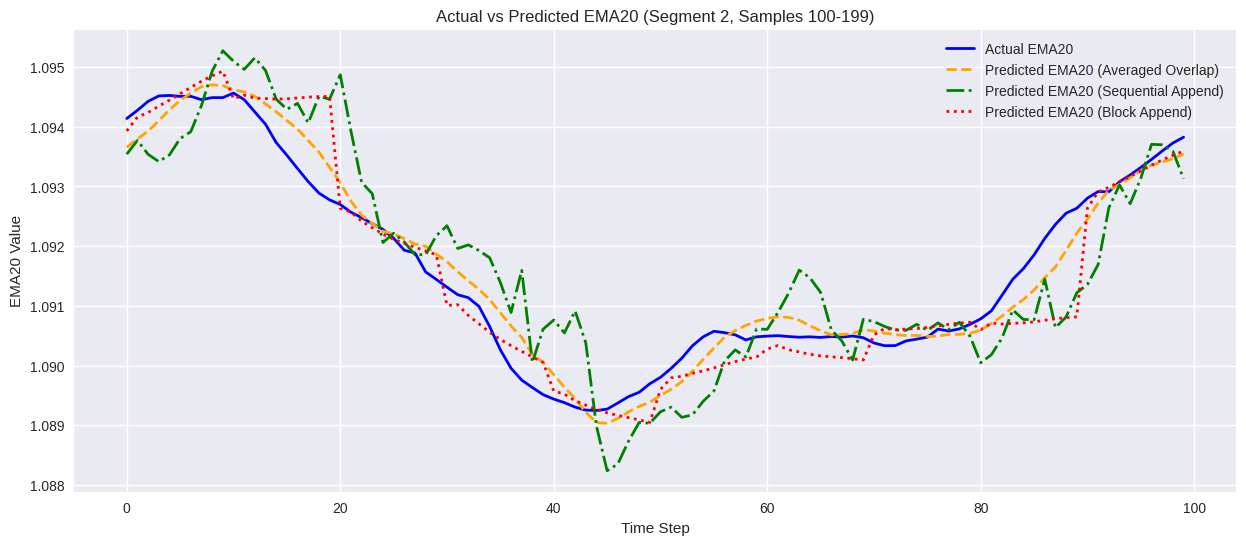

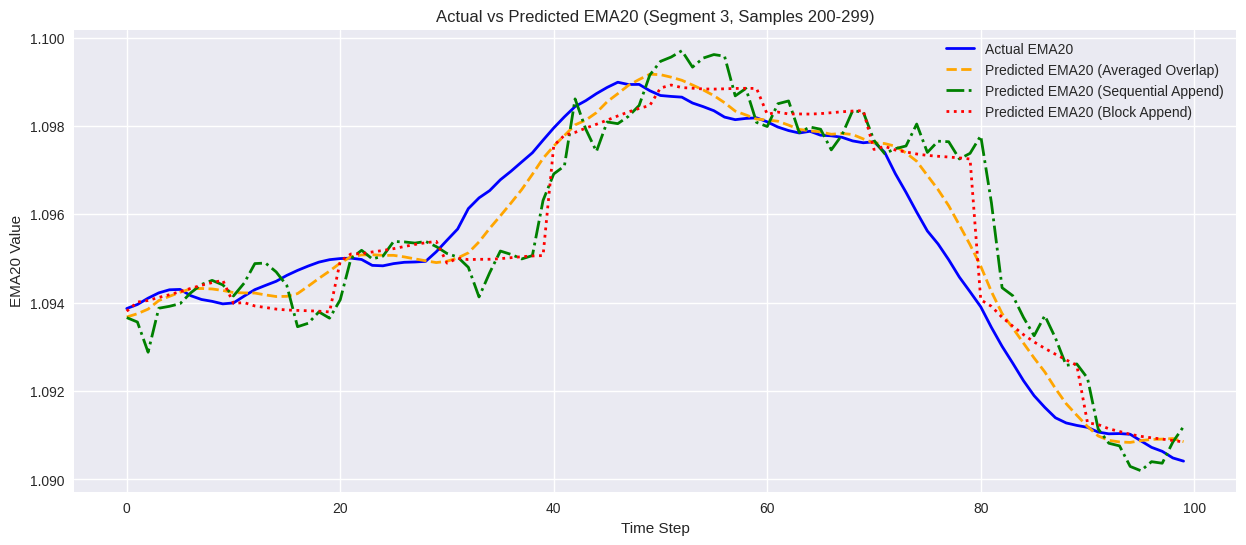

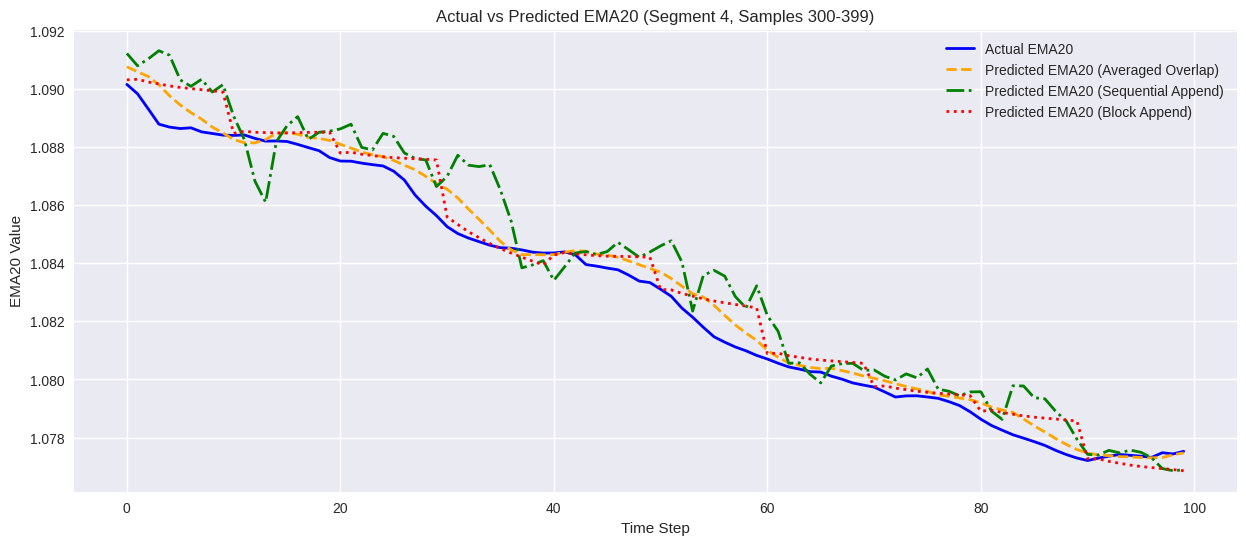

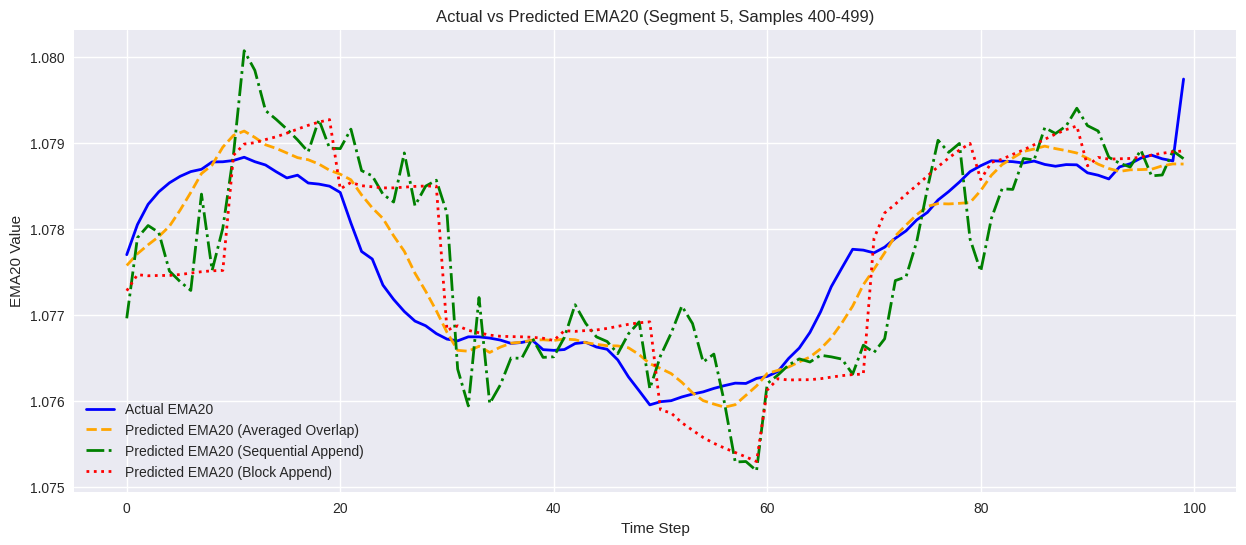

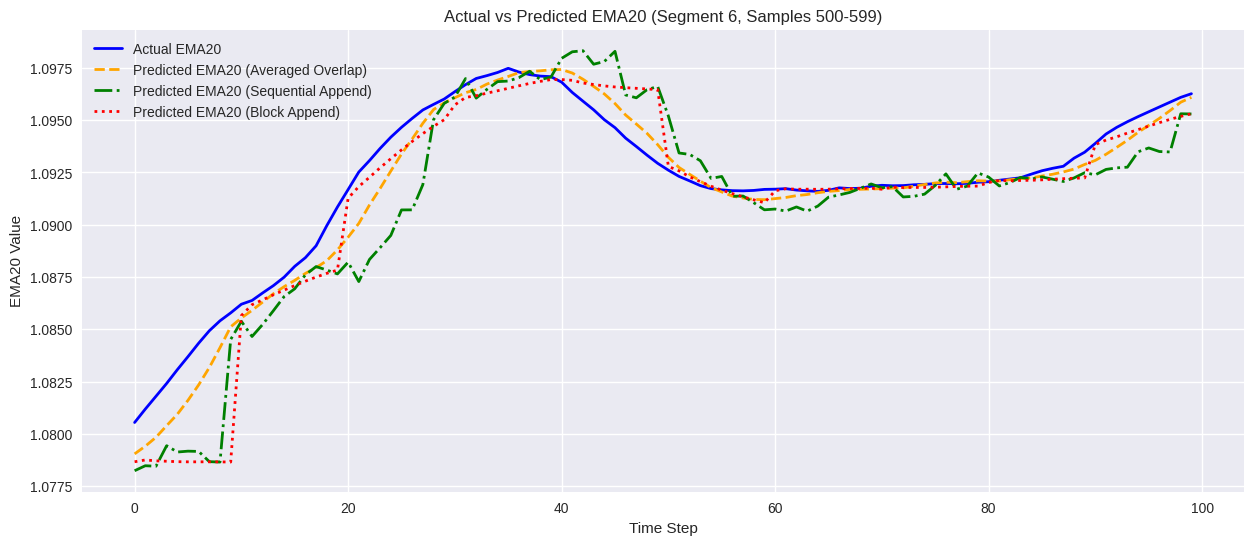

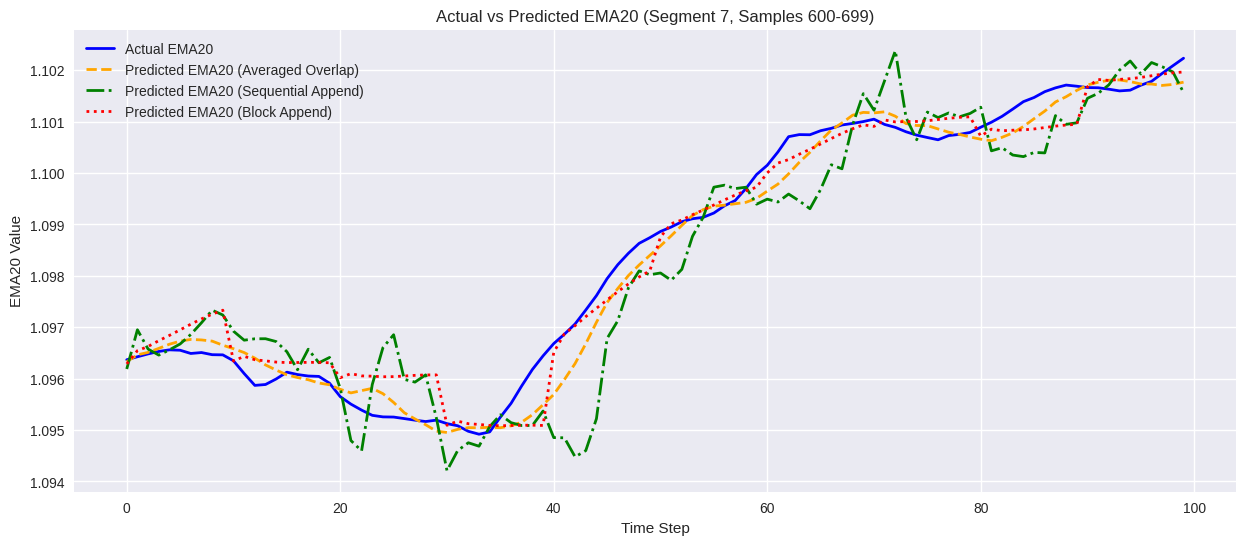

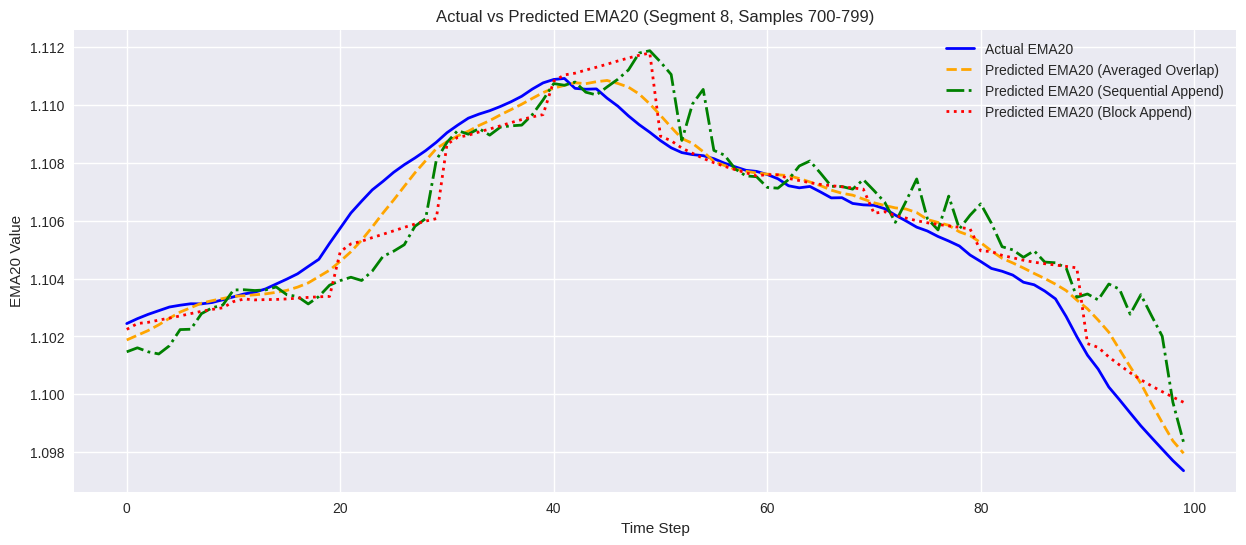

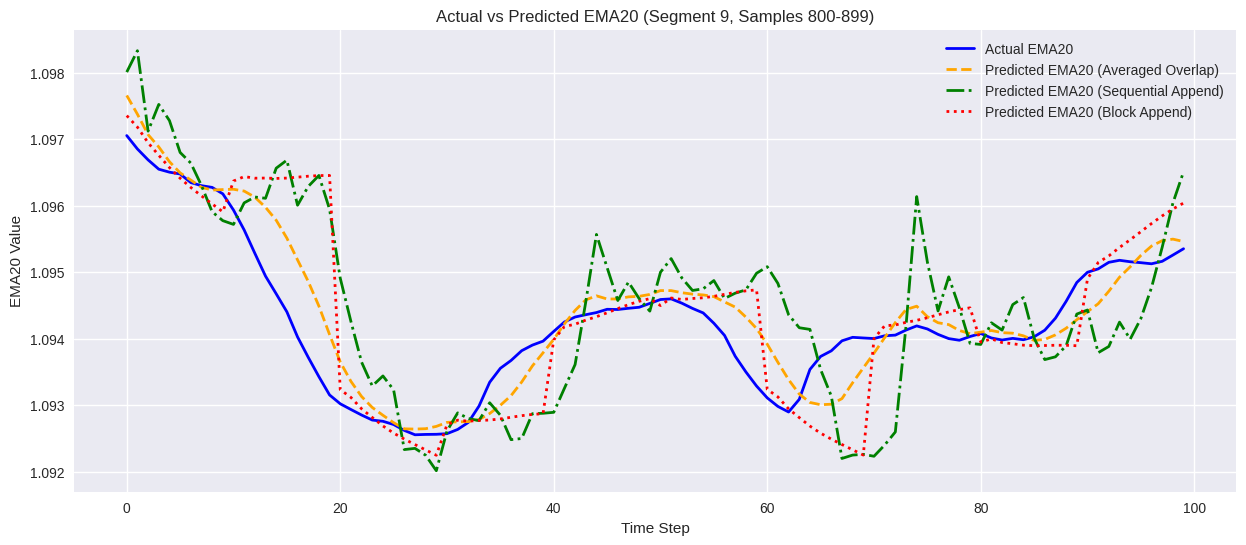

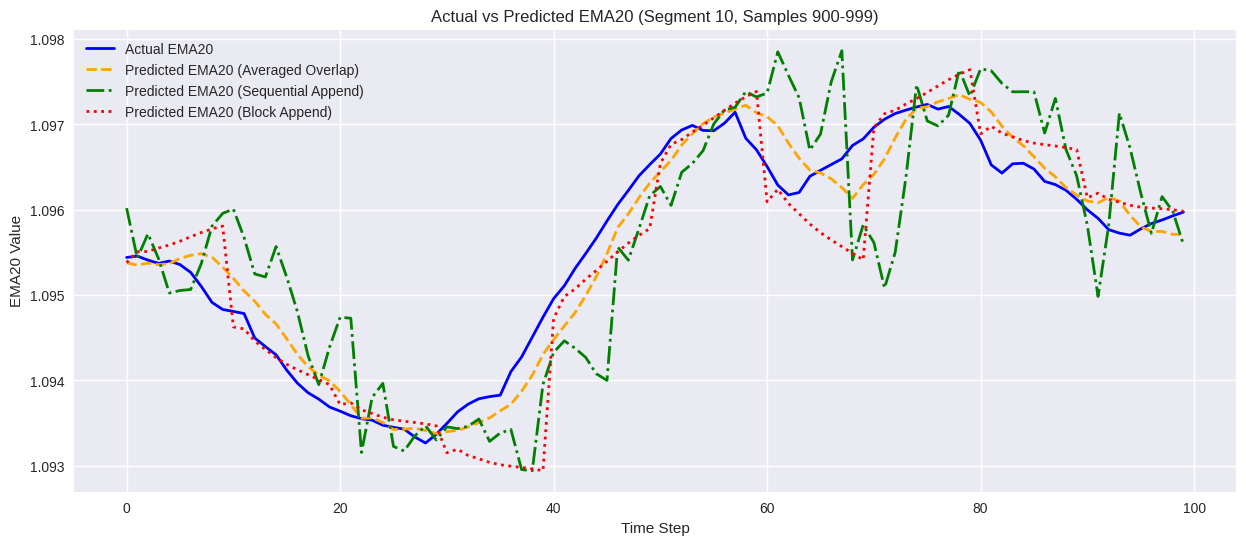

Number of segments plotted: 10


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# فرض می‌کنیم data, X_test, y_pred, scaler_target از اجرای کد قبلی در دسترس هستند
# پارامترها
seq_length = 72
future_steps = 10

# 1. استخراج سری زمانی واقعی EMA20 برای بازه تست
test_start_idx = len(data) - len(X_test) - future_steps  # شروع بازه تست
test_end_idx = len(data)  # پایان بازه تست
actual_ema20 = data['ema20'].values[test_start_idx:test_end_idx]

# 2. معکوس کردن نرمال‌سازی پیش‌بینی‌ها
y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(-1, future_steps))  # پیش‌بینی‌ها برای هر دنباله

# 3. راهبرد اول: میانگین‌گیری با در نظر گرفتن هم‌پوشانی
n_test_samples = len(X_test)  # تعداد دنباله‌های تست
pred_length = n_test_samples + future_steps - 1  # طول کل بازه پیش‌بینی
pred_avg = np.zeros(pred_length)  # آرایه برای ذخیره میانگین‌ها
counts = np.zeros(pred_length)  # آرایه برای شمارش تعداد پیش‌بینی‌ها برای هر نقطه

# پر کردن مقادیر پیش‌بینی
for i in range(n_test_samples):
    for j in range(future_steps):
        pred_idx = i + j
        pred_avg[pred_idx] += y_pred_inv[i, j]
        counts[pred_idx] += 1

# محاسبه میانگین
pred_avg = pred_avg / counts

# 4. راهبرد دوم: استفاده از پیش‌بینی نمونه اول برای 10 گام اول، سپس الحاق آخرین پیش‌بینی‌ها
pred_sequential = []

# گام‌های 72 تا 81: استفاده از پیش‌بینی نمونه اول (y_pred[0])
if n_test_samples > 0:
    pred_sequential.extend(y_pred_inv[0])  # 10 مقدار اول از نمونه اول

# از گام 82 به بعد: الحاق آخرین پیش‌بینی هر نمونه
for i in range(1, n_test_samples):
    last_pred = y_pred_inv[i, -1]  # آخرین گام پیش‌بینی (گام 10ام)
    pred_sequential.append(last_pred)

# تبدیل به آرایه numpy
pred_sequential = np.array(pred_sequential)

# 5. راهبرد سوم: الحاق بلوک‌های 10 تایی
pred_block = []

# گام‌های 72 تا 81: استفاده از پیش‌بینی نمونه اول (y_pred[0])
if n_test_samples > 0:
    pred_block.extend(y_pred_inv[0])  # 10 مقدار اول از نمونه اول

# از گام 82 به بعد: هر 10 نمونه یک‌بار، کل بلوک 10 تایی را الحاق می‌کنیم
# نمونه‌های 9، 19، 29، ... (به فاصله 10)
for i in range(9, n_test_samples, 10):  # از نمونه 9 شروع می‌کنیم (برای گام‌های 81 تا 90)
    pred_block.extend(y_pred_inv[i])  # کل 10 پیش‌بینی این نمونه

# تبدیل به آرایه numpy
pred_block = np.array(pred_block)

# 6. تنظیم طول‌ها برای رسم
min_length = min(len(actual_ema20), len(pred_avg), len(pred_sequential), len(pred_block))
actual_ema20 = actual_ema20[:min_length]
pred_avg = pred_avg[:min_length]
pred_sequential = pred_sequential[:min_length]
pred_block = pred_block[:min_length]

# 7. تقسیم داده‌ها به بسته‌های 100 تایی و رسم 10 نمودار
segment_size = 100  # اندازه هر بسته
n_segments = min(10, min_length // segment_size)  # حداکثر 10 نمودار

for segment in range(n_segments):
    start_idx = segment * segment_size
    end_idx = (segment + 1) * segment_size
    
    # استخراج داده‌های بسته فعلی
    actual_segment = actual_ema20[start_idx:end_idx]
    pred_avg_segment = pred_avg[start_idx:end_idx]
    pred_sequential_segment = pred_sequential[start_idx:end_idx]
    pred_block_segment = pred_block[start_idx:end_idx]
    
    # رسم نمودار برای بسته فعلی
    plt.figure(figsize=(15, 6))
    plt.plot(actual_segment, label='Actual EMA20', color='blue', linewidth=2)
    plt.plot(pred_avg_segment, label='Predicted EMA20 (Averaged Overlap)', color='orange', linestyle='--', linewidth=2)
    plt.plot(pred_sequential_segment, label='Predicted EMA20 (Sequential Append)', color='green', linestyle='-.', linewidth=2)
    plt.plot(pred_block_segment, label='Predicted EMA20 (Block Append)', color='red', linestyle=':', linewidth=2)
    plt.title(f'Actual vs Predicted EMA20 (Segment {segment + 1}, Samples {start_idx}-{end_idx - 1})')
    plt.xlabel('Time Step')
    plt.ylabel('EMA20 Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# چاپ تعداد نمودارهای رسم‌شده
print(f'Number of segments plotted: {n_segments}')